In [1]:
import torch
import numpy as np
import pickle
import gzip
import numpy as np
import os
from torchvision import transforms
from unet import UNet
import PIL
from PIL import Image
import torchvision.models as models
from tqdm import tqdm
from matplotlib import pyplot as plt
import medpy.filter.smoothing as mp

from sklearn.decomposition import NMF
from skimage import exposure
import elasticdeform.torch as etorch

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [4]:
def crop_resize(image_obj, coords, x_size, y_size):
    width = image_obj.size[0]
    height = image_obj.size[1]
    coords = (coords[0]*width, coords[1]*height, coords[2]*width, coords[3]*height)
    cropped_image = image_obj.crop(coords)
    resized_image = cropped_image.resize((x_size, y_size), Image.ANTIALIAS)
    return(resized_image)

def augment(image, x_size, y_size, label=None):
    ratio = np.random.random()*(4/3-3/4)+3/4
    area = np.random.random()*0.5+0.5
    rot = (np.random.random()*2-1)*10
    h = np.sqrt(area/ratio)
    w = h*ratio
    x = (1 - w)*np.random.random()
    y = (1 - h)*np.random.random()
    crop_rect = (x,y, x+w, y+h)
        
    b = np.random.random()
    
    image = crop_resize(image, crop_rect, x_size, y_size)
    image = image.rotate(rot)
    converter = PIL.ImageEnhance.Brightness(image)
    #image = transforms.ToPILImage()(transforms.ToTensor()(converter.enhance((1.4-0.6)*b+0.6))+(torch.rand(image.size)-0.5)*1e-3)
    image = transforms.ToPILImage()(transforms.ToTensor()(converter.enhance(1))+(torch.rand(image.size)-0.5)*1e-3)
    image = transforms.Grayscale()(image)
    if label:
        label = label.rotate(rot)
        label = crop_resize(label, crop_rect, x_size, y_size)
        label = transforms.Grayscale()(label)
        return image, label
    return image

In [5]:
def rnmf(matrix2d, sparsity_coef, max_iter):
    i = 0
    model = NMF(n_components=2, init='random', random_state=0,
                max_iter=2000, tol=0.00001)
    W = model.fit_transform(matrix2d)
    H = model.components_

    while i <= max_iter:
        W_old = W
        H_old = H
        # initialize S matrix
        S = matrix2d - np.matmul(W_old, H_old)

        # update S matrix
        S[S > sparsity_coef / 2] = S[S > sparsity_coef / 2] - sparsity_coef / 2
        S[S < sparsity_coef / 2] = 0

        # update W matrix
        W_new = W_old * (np.matmul(np.maximum(matrix2d - S, 0), H_old.T)) / \
                (np.matmul(np.matmul(W_old, H_old), H_old.T))
        nan_ind = np.isnan(W_new)
        inf_ind = np.isinf(W_new)
        W_new[nan_ind] = 0
        W_new[inf_ind] = 1
        W_new = W_new / np.linalg.norm(W_new, ord='fro', keepdims=True)

        # update H matrix
        H_new = H_old * (np.matmul(W_new.T, np.maximum(matrix2d - S, 0))) / \
                (np.matmul(np.matmul(W_new.T, W_new), H_old))
        nan_ind = np.isnan(H_new)
        inf_ind = np.isinf(H_new)
        H_new[nan_ind] = 0
        H_new[inf_ind] = 1

        # normalize W and H
        W = W_new
        # H = H_new
        H = H_new * np.linalg.norm(W_new, ord='fro', keepdims=True)
        i += 1

    return W, H, S

In [6]:
def RNMF_transform(video, max_iter = 150, sparsity_coef = 0.2):
    video = video / 255
    nf = video.shape[2]
    x = video.shape[0]
    y = video.shape[1]
    t = np.zeros((x*nf, y))
    for i in range(x*nf):
        for j in range(y):
            t[i][j] = video[i%x][j][i//x]
    
    W, H, S = rnmf(t, sparsity_coef, max_iter)
    
    new_video = np.zeros((x, y, nf))
    for i in range(x):
        for j in range(y):
            for k in range(nf):
                new_video[i][j][k] = S[i + x*k][j]
    return new_video

In [7]:
class Custom_dataset(torch.utils.data.Dataset):
    def __init__(self,
                 file_name,
                 chosen_indexes = [],
                 box_train = False,
                 augmented = False,
                 randomize = True,
                RNMF = False,
                RNMF_data = None,
                size = (64, 64),
                crop_box = False,
                exposure = True,
                box_model = None):
        self.data = load_zipped_pickle(file_name)
        if len(chosen_indexes)>0:
            self.data = list([self.data[i] for i in chosen_indexes])
        
        if RNMF:
            if RNMF_data is not None:
                self.data = RNMF_data
            else:
                for i in tqdm(range(len(self.data))):
                    x = self.data[i]['video'].shape[0]
                    self.data[i]['video'] = RNMF_transform(self.data[i]['video'])
        self.augmented = augmented
        self.video_index = []
        self.names = []
        self.box_train = box_train
        self.crop_box = crop_box
        self.exposure = exposure
        self.box_model = box_model
        
        self.size = size
        
        
        if box_train:
            count = 0
            for i in range(len(self.data)):
                self.video_index.append(count)
                count += self.data[i]['video'].shape[2]
                for _ in range(self.data[i]['video'].shape[2]):
                    self.names.append(self.data[i]['name'])
            self.video_index.append(count)
                
            self.indexer = list(range(count))
        else:
            for i in range(len(self.data)):
                for _ in range(3):
                    self.names.append(self.data[i]['name'])
            self.indexer = list(range(len(self.data)*3))
            
        if randomize:
            np.random.shuffle(self.indexer)
            
        self.names = [self.names[self.indexer[i]] for i in range(len(self.indexer))]
            
        self.transform = transforms.Compose([
                                transforms.Grayscale(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=0.438,
                                                    std=0.378),
                              #transforms.Normalize(mean=0.591,
                              #                     std = 1)
                              #                      std=0.189),
                              transforms.RandomErasing(p=0.3*int(augmented), scale=(0.02, 0.2),
                                                       ratio=(0.3, 3.3), value=0,
                                                       inplace=False)
                        ])
    def __getitem__(self, index):
        real_idx = self.indexer[index]
        if self.box_train:
            old_count = 0
            for i, count in enumerate(self.video_index):
                if real_idx >= count:
                    old_count = count
                    continue
                else:
                    #t = torch.Tensor(exposure.equalize_hist(self.data[i-1]['video'][:, :, real_idx - old_count]))
                    t = torch.Tensor(self.data[i-1]['video'][:, :, real_idx - old_count])
                    image = transforms.ToPILImage()(t)
                    box = transforms.ToPILImage()(torch.Tensor(self.data[i-1]['box']))
                    if self.augmented:
                        image, box = augment(image, self.size[0], self.size[1], box)
                    else:
                        image = image.resize(self.size)
                        box = box.resize(self.size)
                    label_box = torch.Tensor([max(0, min(np.where(box)[1])/box.size[1] - 0.08),
                                              max(0, min(np.where(box)[0])/box.size[0] - 0.08),
                                              min(1, 0.16 + max(np.where(box)[1])/box.size[1]) - min(np.where(box)[1])/box.size[1],
                                              min(1, 0.16 + max(np.where(box)[0])/box.size[0]) - min(np.where(box)[0])/box.size[0]])
                    
                    return self.transform(image), label_box
        else:
            if self.exposure:
                image = transforms.ToPILImage()(torch.Tensor(exposure.equalize_hist(self.data[real_idx//3]['video'][:, :, self.data[real_idx//3]['frames'][real_idx%3]])))
            else:
                image = transforms.ToPILImage()(torch.Tensor(self.data[real_idx//3]['video'][:, :, self.data[real_idx//3]['frames'][real_idx%3]]))
            label = transforms.ToPILImage()(torch.Tensor(self.data[real_idx//3]['label'][:, :, self.data[real_idx//3]['frames'][real_idx%3]]))
            if self.crop_box:
                if self.box_model is None:
                    box = transforms.ToPILImage()(torch.Tensor(self.data[real_idx//3]['box']))
                    image = crop_resize(image, [min(np.where(box)[1])/box.size[0],
                                                min(np.where(box)[0])/box.size[1],
                                                max(np.where(box)[1])/box.size[0],
                                                max(np.where(box)[0])/box.size[1]],
                                       self.size[0],
                                       self.size[1])
                    label = crop_resize(label, [min(np.where(box)[1])/box.size[1],
                                                min(np.where(box)[0])/box.size[0],
                                                max(np.where(box)[1])/box.size[1],
                                                max(np.where(box)[0])/box.size[0]],
                                       self.size[0],
                                       self.size[1])
                else:
                    box_coords = self.box_model(self.transform(image.resize((128,128))).unsqueeze(0).cuda())[0].detach().cpu().numpy()
                    box_coords = [box_coords[0], box_coords[1],
                                 box_coords[2] + box_coords[0], box_coords[1] + box_coords[3]]
                    image = crop_resize(image, box_coords,
                                       self.size[0],
                                       self.size[1])
                    label = crop_resize(label, box_coords,
                                       self.size[0],
                                       self.size[1])
            if self.augmented:
                image, label = augment(image, self.size[0], self.size[1], label)
            else:
                image = image.resize(self.size)
                label = label.resize(self.size)

            x = self.transform(image)
            label = transforms.ToTensor()(transforms.Grayscale()(label))
            
            if self.augmented:
                displacement = np.random.randn(2, 3, 3) * 5
                displacement = torch.tensor(displacement)

                x[0] = etorch.deform_grid(x[0], displacement)
                label[0] = etorch.deform_grid(label[0], displacement)
                
            return x, label
        print('error', real_idx, self.video_index)
    def __len__(self):
        return(len(self.indexer))

In [8]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2] + boxA[0], boxB[2] + boxB[0])
	yB = min(boxA[3] + boxA[1], boxB[3] + boxB[1])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [9]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)
        
        assert target.shape == prediction.shape
        assert np.max(target)
            
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    #print("Median IOU: ", np.median(ious))
    return np.median(ious)
    
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 validation_names: list = [],
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 box_training: bool = False
                 ):

        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.validation_names = validation_names
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.box_training = box_training
        self.best_score = 0

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        best_score = 0
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                print(best_score)
                score = self._validate()
            
            if self.box_training:
                name = 'best_model_box_128_roi_exp_bis.pth'
            else:
                name = 'best_model_unet_nobo_128_thirtyeighth.pth'
                
            if score > best_score:
                torch.save(self.model.state_dict(), name)
                best_score = score
                print('saved with score: ', best_score)
                self.best_score = best_score

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.step()  # learning rate scheduler step
        self.model.load_state_dict(torch.load(name))
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            if self.box_training:
                out = self.model(input) # one forward pass
            else:
                out = self.model(input).clamp(0,1) # one forward pass
            """print(target[0][0][torch.argmax(target)//128][torch.argmax(target)%128])
            print(out[0][0][torch.argmax(target)//128][torch.argmax(target)%128])
            print(out[0][1][torch.argmax(target)//128][torch.argmax(target)%128])
            print(target[0][0][0][0])
            print(out[0][0][0][0])
            print(out[0][1][0][0])"""
            loss = self.criterion(out, target)  # calculate loss

            #print(torch.max((torch.argmax(out, dim = 1)).float().cpu()) , torch.max(target.squeeze(dim = 1).cpu()))
            
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)
        
        predictions = []
        targets = []
        ious = []
        
        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            #target = target.type(torch.cuda.LongTensor)

            with torch.no_grad():
                if self.box_training:
                    out = self.model(input)
                else:
                    out = self.model(input).clamp(0,1)
                    if i%12 == 0:
                        display(transforms.ToPILImage()((out>0.5).float()[0]))
                        display(transforms.ToPILImage()(target[0]))
                #loss = self.criterion(out, target.squeeze(dim = 1)).mean()
                loss = self.criterion(out, target)
            
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')
                
                for k in range(out.size(0)):
                    if not self.box_training:
                        #p = {'name': self.validation_names[i], 'prediction': (torch.argmax(out, dim = 1)).float().cpu()}
                        #t = {'name': self.validation_names[i], 'label': target.squeeze(dim = 1).cpu()}
                        p = {'name': self.validation_names[i], 'prediction': (out[k]>0.5).cpu()}
                        t = {'name': self.validation_names[i], 'label': target[k].cpu()}

                        predictions.append(p)
                        targets.append(t)

                        evaluate(predictions, targets)
                    else:
                        ious.append(bb_intersection_over_union(out[k].cpu(), target[k].cpu()).item())

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()
        if self.box_training:
            print("Median IOU: ", np.median(ious))
            return np.median(ious)
        else:
            print("Median IOU: ", evaluate(predictions, targets))
            return evaluate(predictions, targets)

In [10]:
chosen_indexes = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 46, 47, 48, 49, 50, 52, 53, 54, 56, 57,
       58, 59, 62, 64, 44, 63, 60, 45, 61, 51, 40])
box_chosen_indexes = np.array([0, 2, 5, 7,  8,  9, 10, 37, 38, 39, 41, 46, 47, 48, 49, 50, 52, 53, 54, 56, 57,
       58, 59, 62, 64])

In [12]:
eval_indexes = np.array([43, 55, 42])
box_eval_indexes = np.array([9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [12]:
box_train_ds = Custom_dataset('train.pkl', chosen_indexes = box_chosen_indexes,
                          box_train = True, augmented = True, randomize = True,
                          size = (128, 128), crop_box = False, RNMF=False, exposure = True)
box_eval_ds = Custom_dataset('train.pkl', chosen_indexes = box_eval_indexes,
                         box_train = True, augmented = False, randomize = False,
                         size = (128, 128), crop_box = False, RNMF = False, exposure = True)

In [15]:
save_zipped_pickle(box_train_ds, 'train_ds.pkl')
save_zipped_pickle(box_eval_ds, 'eval_ds.pkl')

In [17]:
torch.cuda.is_available()

True

In [11]:
box_train_ds = load_zipped_pickle('train_ds.pkl')
box_eval_ds = load_zipped_pickle('eval_ds.pkl')

In [13]:
dataloader_training = torch.utils.data.DataLoader(box_train_ds, batch_size = 100, shuffle = True)
dataloader_validation = torch.utils.data.DataLoader(box_eval_ds, batch_size = 1, shuffle = True)

In [14]:
def classifier(out_size, num_classes):
    classifier = torch.nn.Sequential(torch.nn.Linear(out_size, int(out_size/2)), torch.nn.BatchNorm1d(int(out_size/2)) , torch.nn.ReLU(),
                               torch.nn.Dropout(p=0.1), torch.nn.Linear(int(out_size/2), num_classes))
    return(classifier)

def Resnet50(num_classes, in_channels):
    net = models.resnet50(pretrained=False)
    net.conv1 = torch.nn.Conv2d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
    out_size = net.fc.in_features
    net.fc = classifier(out_size, num_classes)
    return(net)

In [22]:
# criterion
device = torch.device('cuda')
model = Resnet50(num_classes = 4,
                 in_channels = 1)
model.load_state_dict(torch.load('best_model_box_128_roi_exp.pth'))

#criterion = torch.nn.CrossEntropyLoss(reduction='none')
criterion = torch.nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# trainer
# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  validation_names = box_eval_ds.names,
                  lr_scheduler=torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.99),
                  epochs=100,
                  epoch=0,
                  notebook=True,
                 box_training= True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

0


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9238928556442261
saved with score:  0.9238928556442261


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.8582454323768616


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.91988205909729


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.8832107186317444


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.8930199146270752


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9228525757789612


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9212507009506226


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.881698489189148


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.8920164108276367


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9238928556442261


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9288305640220642
saved with score:  0.9288305640220642


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9288305640220642


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9055365920066833


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9288305640220642


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9190352559089661


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9288305640220642


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9294713139533997
saved with score:  0.9294713139533997


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9198532700538635


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.8984615802764893


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9076524972915649


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.891995370388031


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9135118722915649


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.8983800411224365


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.8898274898529053


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9210802912712097


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9197786450386047


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9294713139533997


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9315314888954163
saved with score:  0.9315314888954163


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9225295782089233


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.8941469192504883


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9246026277542114


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9212540984153748


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9168310165405273


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9165037274360657


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9188818335533142


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9037963151931763


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9237194061279297


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315314888954163


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9315641522407532
saved with score:  0.9315641522407532


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315641522407532


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9160675406455994


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315641522407532


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9263054132461548


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315641522407532


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9154620170593262


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315641522407532


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9170642495155334


Training:   0%|          | 0/32 [00:00<?, ?it/s]

0.9315641522407532


Validation:   0%|          | 0/1875 [00:00<?, ?it/s]

Median IOU:  0.9175658226013184


Training:   0%|          | 0/32 [00:00<?, ?it/s]

ValueError: min() arg is an empty sequence

In [23]:
model = Resnet50(num_classes = 4,
                 in_channels = 1).cuda()
model.load_state_dict(torch.load('best_model_box_128_roi_exp.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
train_ds = Custom_dataset('train.pkl', chosen_indexes = chosen_indexes,
                          box_train = False, augmented = True, randomize = True,
                          size = (128, 128), crop_box = False, RNMF=True, exposure = False, box_model = None, RNMF_data = train_ds.data)
eval_ds = Custom_dataset('train.pkl', chosen_indexes = eval_indexes,
                         box_train = False, augmented = False, randomize = False,
                         size = (128, 128), crop_box = False, RNMF = True, exposure = False, box_model = None, RNMF_data = eval_ds.data)

In [74]:
train_ds2 = Custom_dataset('train.pkl', chosen_indexes = chosen_indexes,
                          box_train = False, augmented = True, randomize = True,
                          size = (128, 128), crop_box = False, RNMF=False, exposure = True, box_model = None)
eval_ds2 = Custom_dataset('train.pkl', chosen_indexes = eval_indexes,
                         box_train = False, augmented = False, randomize = False,
                         size = (128, 128), crop_box = False, RNMF = False, exposure = True, box_model = None)

In [75]:
dataloader_training = torch.utils.data.DataLoader(train_ds2, batch_size = 10, shuffle = True)
dataloader_validation = torch.utils.data.DataLoader(eval_ds2, batch_size = 1, shuffle = True)

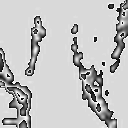

In [18]:
transforms.ToPILImage()(train_ds[2][0][0])

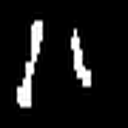

In [19]:
transforms.ToPILImage()(train_ds[2][1][0])

Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

0


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

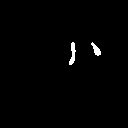

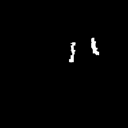

Median IOU:  0.48034934497816595
saved with score:  0.48034934497816595


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

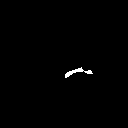

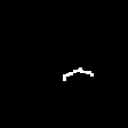

Median IOU:  0.39226519337016574


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

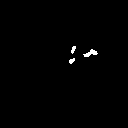

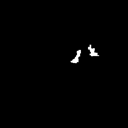

Median IOU:  0.3901098901098901


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

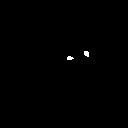

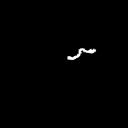

Median IOU:  0.44554455445544555


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

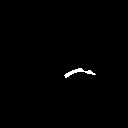

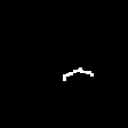

Median IOU:  0.3979591836734694


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

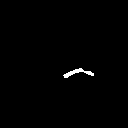

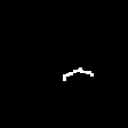

Median IOU:  0.4511627906976744


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

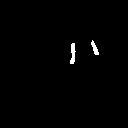

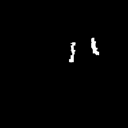

Median IOU:  0.45495495495495497


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

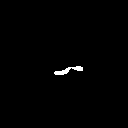

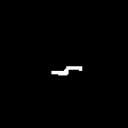

Median IOU:  0.4263959390862944


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

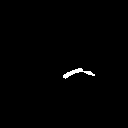

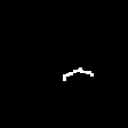

Median IOU:  0.4590909090909091


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48034934497816595


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

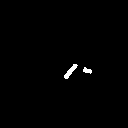

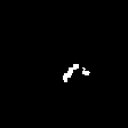

Median IOU:  0.48663101604278075
saved with score:  0.48663101604278075


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48663101604278075


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

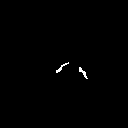

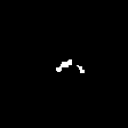

Median IOU:  0.3548387096774194


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48663101604278075


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

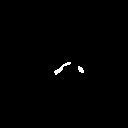

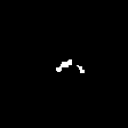

Median IOU:  0.4701195219123506


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48663101604278075


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

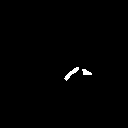

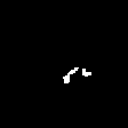

Median IOU:  0.45901639344262296


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48663101604278075


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

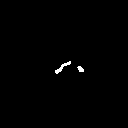

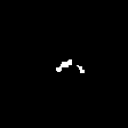

Median IOU:  0.44086021505376344


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48663101604278075


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

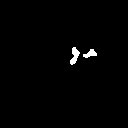

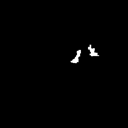

Median IOU:  0.45982142857142855


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48663101604278075


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

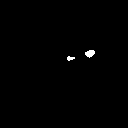

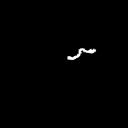

Median IOU:  0.4702702702702703


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48663101604278075


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

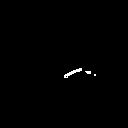

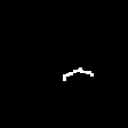

Median IOU:  0.3434343434343434


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.48663101604278075


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

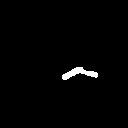

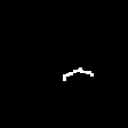

Median IOU:  0.6181102362204725
saved with score:  0.6181102362204725


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

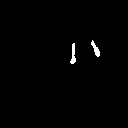

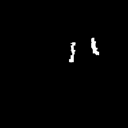

Median IOU:  0.4722222222222222


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

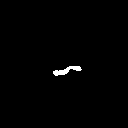

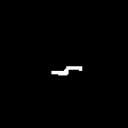

Median IOU:  0.5223214285714286


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

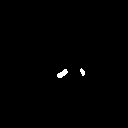

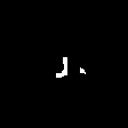

Median IOU:  0.4666666666666667


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

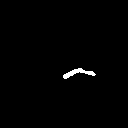

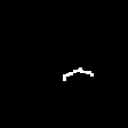

Median IOU:  0.46396396396396394


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

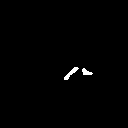

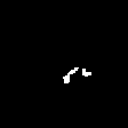

Median IOU:  0.4189189189189189


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

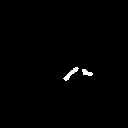

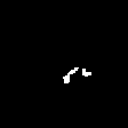

Median IOU:  0.4660633484162896


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

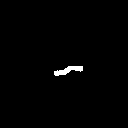

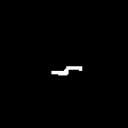

Median IOU:  0.5186721991701245


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

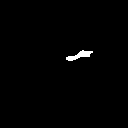

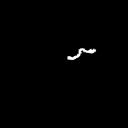

Median IOU:  0.49583333333333335


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

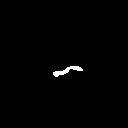

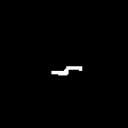

Median IOU:  0.45794392523364486


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

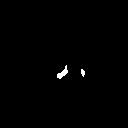

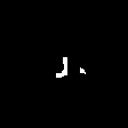

Median IOU:  0.4372093023255814


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

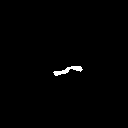

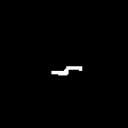

Median IOU:  0.42592592592592593


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

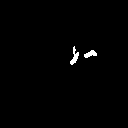

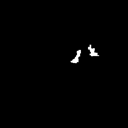

Median IOU:  0.4537037037037037


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

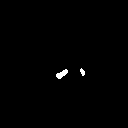

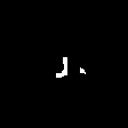

Median IOU:  0.4292237442922374


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

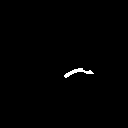

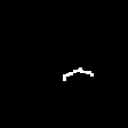

Median IOU:  0.39631336405529954


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

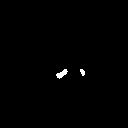

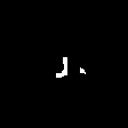

Median IOU:  0.42592592592592593


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

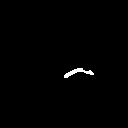

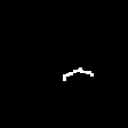

Median IOU:  0.43317972350230416


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

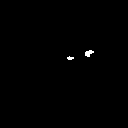

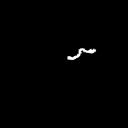

Median IOU:  0.41530054644808745


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

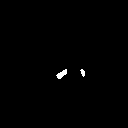

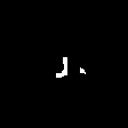

Median IOU:  0.4186046511627907


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

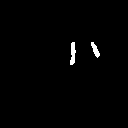

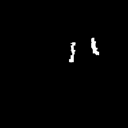

Median IOU:  0.4774774774774775


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

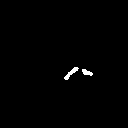

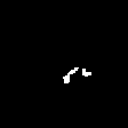

Median IOU:  0.41818181818181815


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

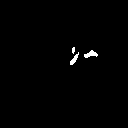

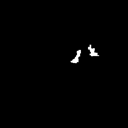

Median IOU:  0.38990825688073394


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

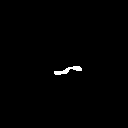

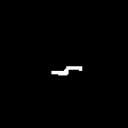

Median IOU:  0.4200913242009132


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

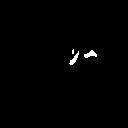

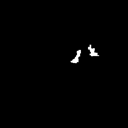

Median IOU:  0.410958904109589


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

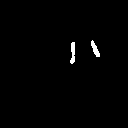

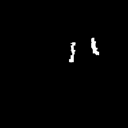

Median IOU:  0.42727272727272725


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

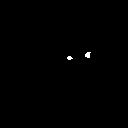

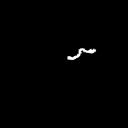

Median IOU:  0.4200913242009132


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

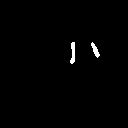

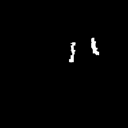

Median IOU:  0.4474885844748858


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

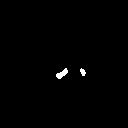

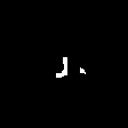

Median IOU:  0.4646017699115044


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

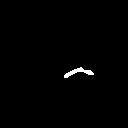

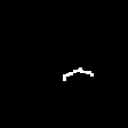

Median IOU:  0.47282608695652173


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

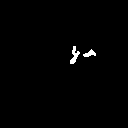

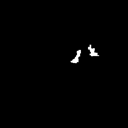

Median IOU:  0.467005076142132


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

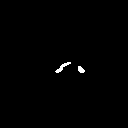

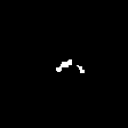

Median IOU:  0.4925373134328358


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

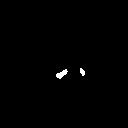

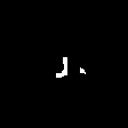

Median IOU:  0.4120603015075377


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

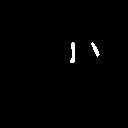

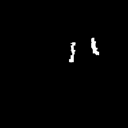

Median IOU:  0.40825688073394495


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

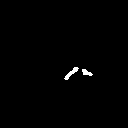

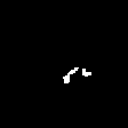

Median IOU:  0.43781094527363185


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

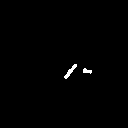

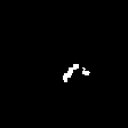

Median IOU:  0.42201834862385323


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

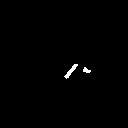

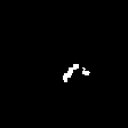

Median IOU:  0.4262295081967213


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

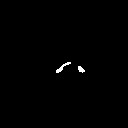

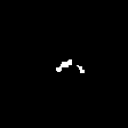

Median IOU:  0.4212962962962963


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

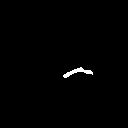

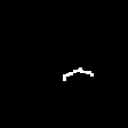

Median IOU:  0.4808743169398907


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

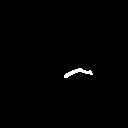

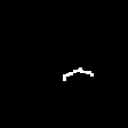

Median IOU:  0.4369747899159664


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

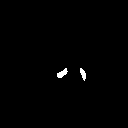

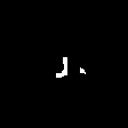

Median IOU:  0.4343891402714932


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

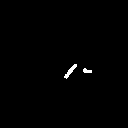

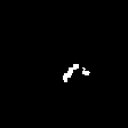

Median IOU:  0.41743119266055045


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

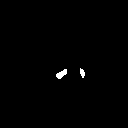

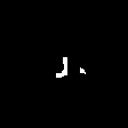

Median IOU:  0.4212962962962963


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

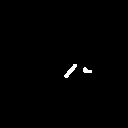

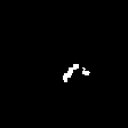

Median IOU:  0.4530386740331492


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

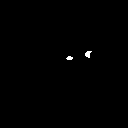

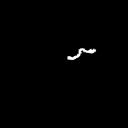

Median IOU:  0.4520547945205479


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

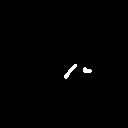

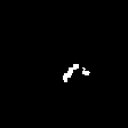

Median IOU:  0.43119266055045874


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

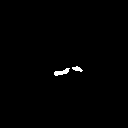

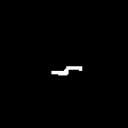

Median IOU:  0.44086021505376344


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

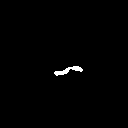

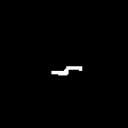

Median IOU:  0.47085201793721976


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

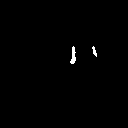

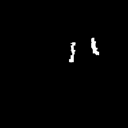

Median IOU:  0.3767441860465116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

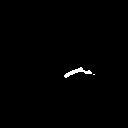

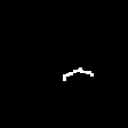

Median IOU:  0.42021276595744683


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

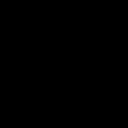

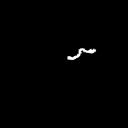

Median IOU:  0.0


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

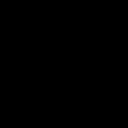

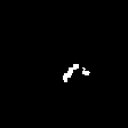

Median IOU:  0.0


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

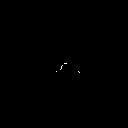

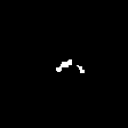

Median IOU:  0.04145077720207254


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

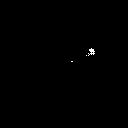

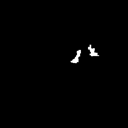

Median IOU:  0.2833333333333333


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

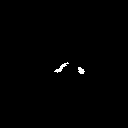

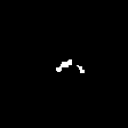

Median IOU:  0.4351851851851852


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

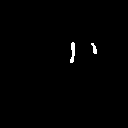

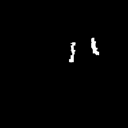

Median IOU:  0.44549763033175355


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

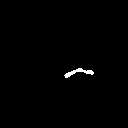

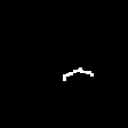

Median IOU:  0.41798941798941797


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

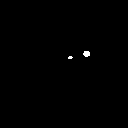

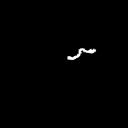

Median IOU:  0.330188679245283


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

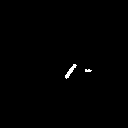

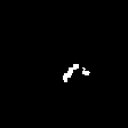

Median IOU:  0.3302752293577982


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

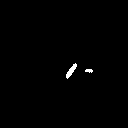

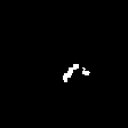

Median IOU:  0.44502617801047123


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

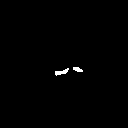

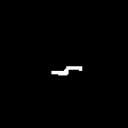

Median IOU:  0.33689839572192515


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

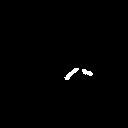

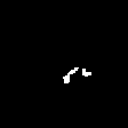

Median IOU:  0.42934782608695654


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

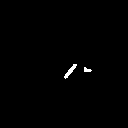

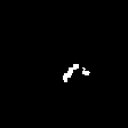

Median IOU:  0.3878504672897196


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

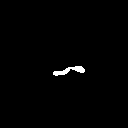

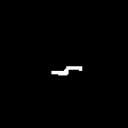

Median IOU:  0.45263157894736844


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

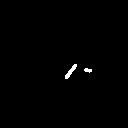

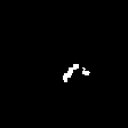

Median IOU:  0.42021276595744683


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

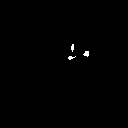

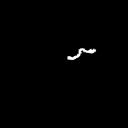

Median IOU:  0.40816326530612246


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

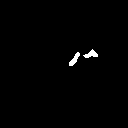

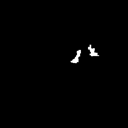

Median IOU:  0.451063829787234


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

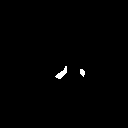

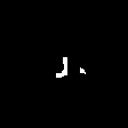

Median IOU:  0.45652173913043476


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

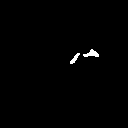

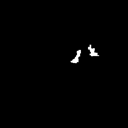

Median IOU:  0.45077720207253885


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

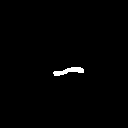

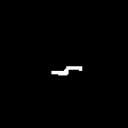

Median IOU:  0.4461538461538462


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

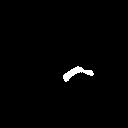

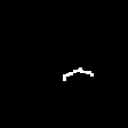

Median IOU:  0.5265151515151515


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

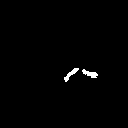

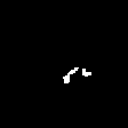

Median IOU:  0.4052863436123348


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

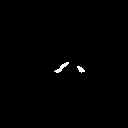

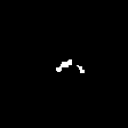

Median IOU:  0.44565217391304346


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

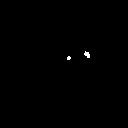

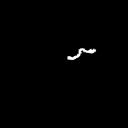

Median IOU:  0.42718446601941745


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

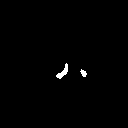

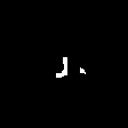

Median IOU:  0.42934782608695654


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

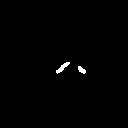

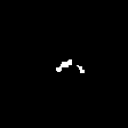

Median IOU:  0.45871559633027525


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

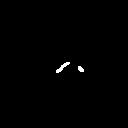

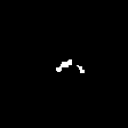

Median IOU:  0.43043478260869567


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

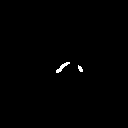

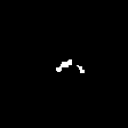

Median IOU:  0.4925373134328358


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

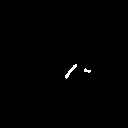

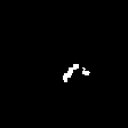

Median IOU:  0.3277777777777778


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

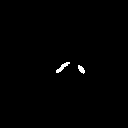

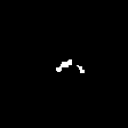

Median IOU:  0.46774193548387094


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

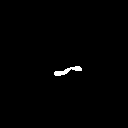

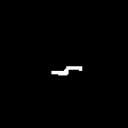

Median IOU:  0.38425925925925924


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

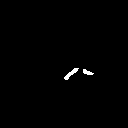

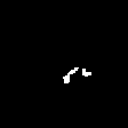

Median IOU:  0.4898989898989899


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

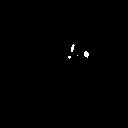

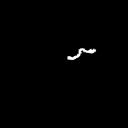

Median IOU:  0.42


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

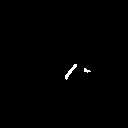

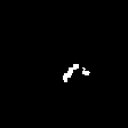

Median IOU:  0.38497652582159625


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

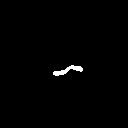

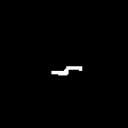

Median IOU:  0.4928909952606635


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

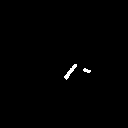

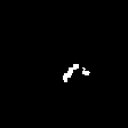

Median IOU:  0.4682926829268293


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

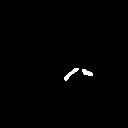

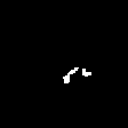

Median IOU:  0.46534653465346537


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

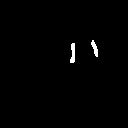

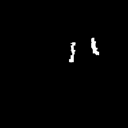

Median IOU:  0.4207920792079208


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

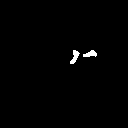

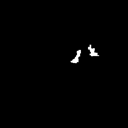

Median IOU:  0.45098039215686275


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

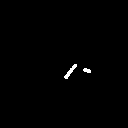

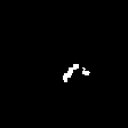

Median IOU:  0.47058823529411764


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

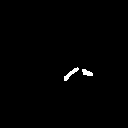

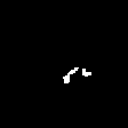

Median IOU:  0.43243243243243246


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

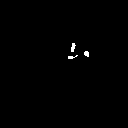

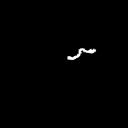

Median IOU:  0.4930232558139535


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

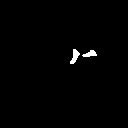

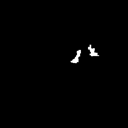

Median IOU:  0.5217391304347826


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

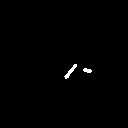

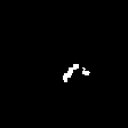

Median IOU:  0.4492753623188406


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

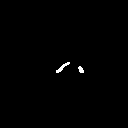

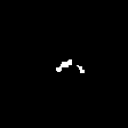

Median IOU:  0.4088669950738916


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

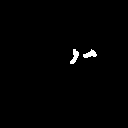

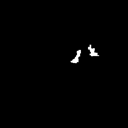

Median IOU:  0.46195652173913043


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

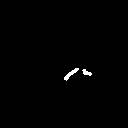

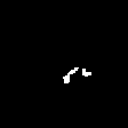

Median IOU:  0.41262135922330095


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

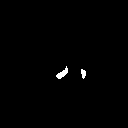

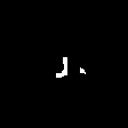

Median IOU:  0.4262295081967213


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

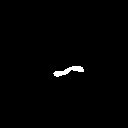

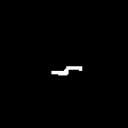

Median IOU:  0.45989304812834225


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

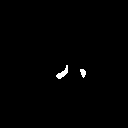

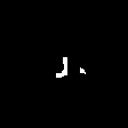

Median IOU:  0.4682926829268293


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

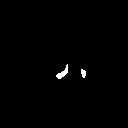

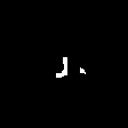

Median IOU:  0.45145631067961167


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

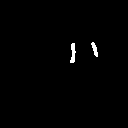

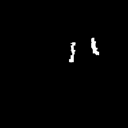

Median IOU:  0.43119266055045874


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

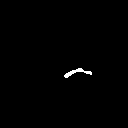

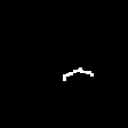

Median IOU:  0.41089108910891087


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

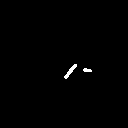

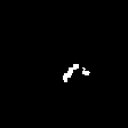

Median IOU:  0.42934782608695654


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

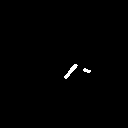

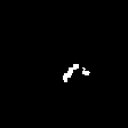

Median IOU:  0.41203703703703703


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

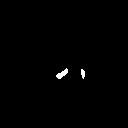

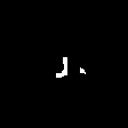

Median IOU:  0.3944954128440367


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

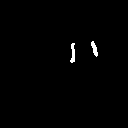

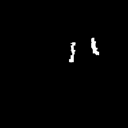

Median IOU:  0.4036697247706422


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

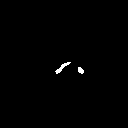

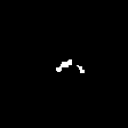

Median IOU:  0.4298642533936652


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

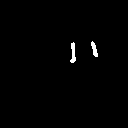

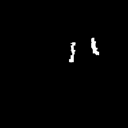

Median IOU:  0.44021739130434784


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

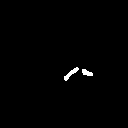

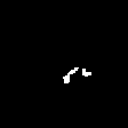

Median IOU:  0.44623655913978494


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

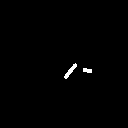

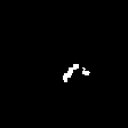

Median IOU:  0.4673913043478261


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

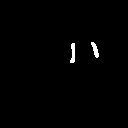

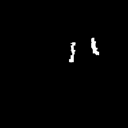

Median IOU:  0.4076086956521739


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

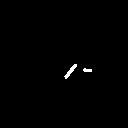

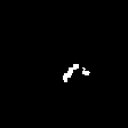

Median IOU:  0.4170403587443946


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

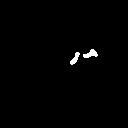

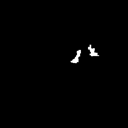

Median IOU:  0.45739910313901344


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

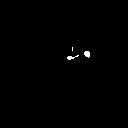

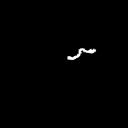

Median IOU:  0.41081081081081083


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

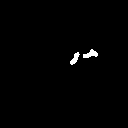

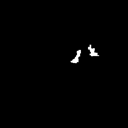

Median IOU:  0.44623655913978494


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

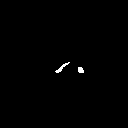

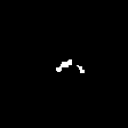

Median IOU:  0.3944954128440367


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

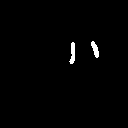

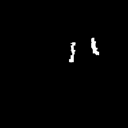

Median IOU:  0.4583333333333333


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

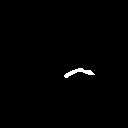

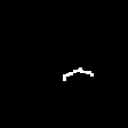

Median IOU:  0.42920353982300885


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

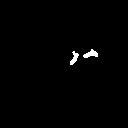

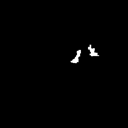

Median IOU:  0.46808510638297873


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

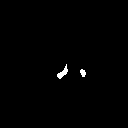

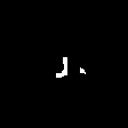

Median IOU:  0.4756756756756757


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

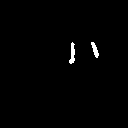

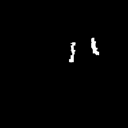

Median IOU:  0.42021276595744683


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

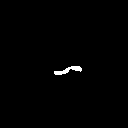

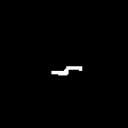

Median IOU:  0.43646408839779005


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

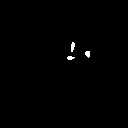

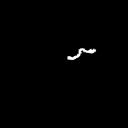

Median IOU:  0.4594594594594595


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

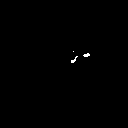

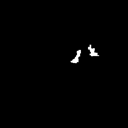

Median IOU:  0.23394495412844038


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

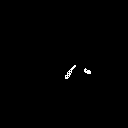

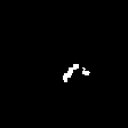

Median IOU:  0.3073394495412844


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

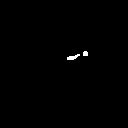

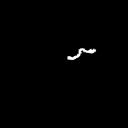

Median IOU:  0.3967391304347826


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

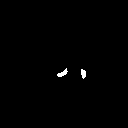

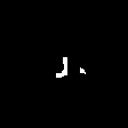

Median IOU:  0.38596491228070173


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

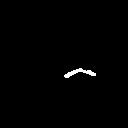

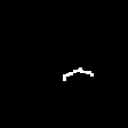

Median IOU:  0.40350877192982454


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

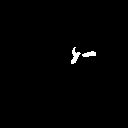

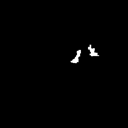

Median IOU:  0.4842105263157895


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

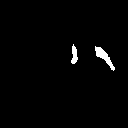

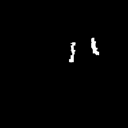

Median IOU:  0.29301075268817206


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

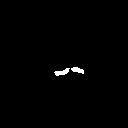

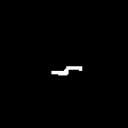

Median IOU:  0.47058823529411764


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

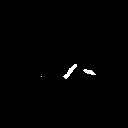

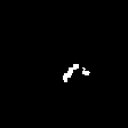

Median IOU:  0.37185929648241206


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

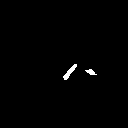

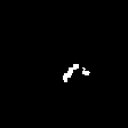

Median IOU:  0.4008438818565401


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

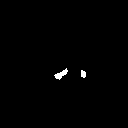

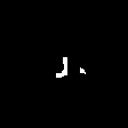

Median IOU:  0.40969162995594716


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

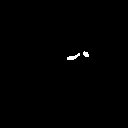

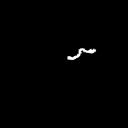

Median IOU:  0.40611353711790393


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

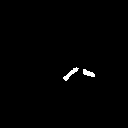

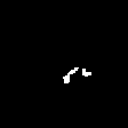

Median IOU:  0.40707964601769914


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

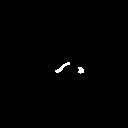

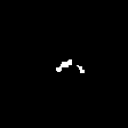

Median IOU:  0.3961352657004831


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

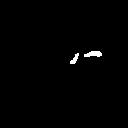

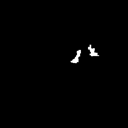

Median IOU:  0.3577586206896552


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

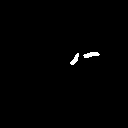

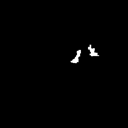

Median IOU:  0.45410628019323673


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

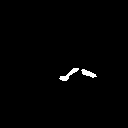

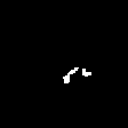

Median IOU:  0.41509433962264153


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

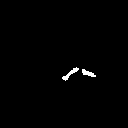

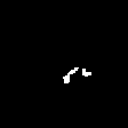

Median IOU:  0.4030612244897959


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

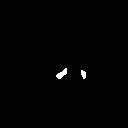

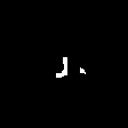

Median IOU:  0.39914163090128757


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

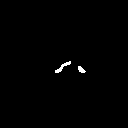

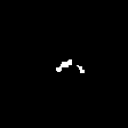

Median IOU:  0.3872549019607843


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

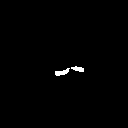

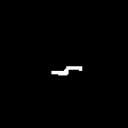

Median IOU:  0.3490566037735849


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

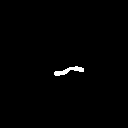

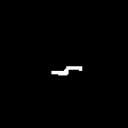

Median IOU:  0.39655172413793105


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

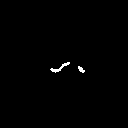

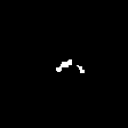

Median IOU:  0.373134328358209


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

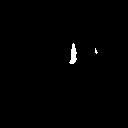

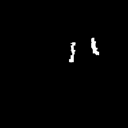

Median IOU:  0.4688995215311005


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

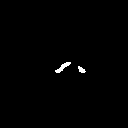

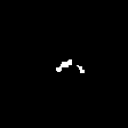

Median IOU:  0.4265402843601896


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

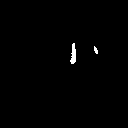

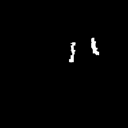

Median IOU:  0.4170403587443946


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

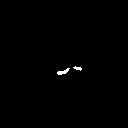

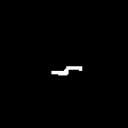

Median IOU:  0.29439252336448596


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

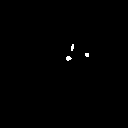

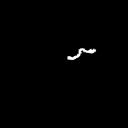

Median IOU:  0.4889867841409692


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

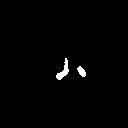

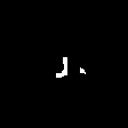

Median IOU:  0.595


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

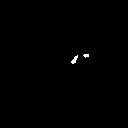

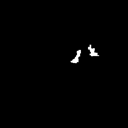

Median IOU:  0.336734693877551


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

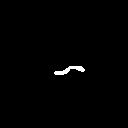

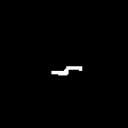

Median IOU:  0.48695652173913045


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

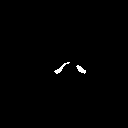

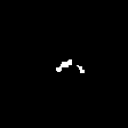

Median IOU:  0.41743119266055045


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

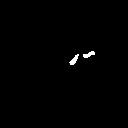

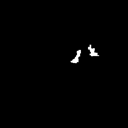

Median IOU:  0.43661971830985913


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

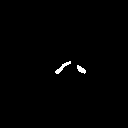

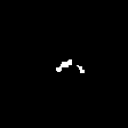

Median IOU:  0.4714285714285714


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

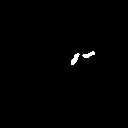

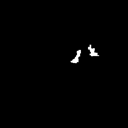

Median IOU:  0.43231441048034935


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

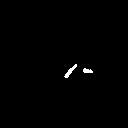

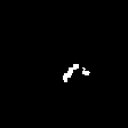

Median IOU:  0.39


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

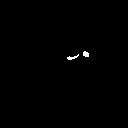

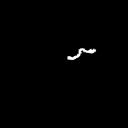

Median IOU:  0.4215686274509804


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

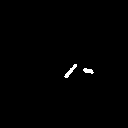

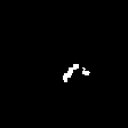

Median IOU:  0.41208791208791207


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

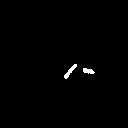

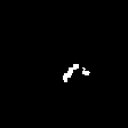

Median IOU:  0.42995169082125606


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

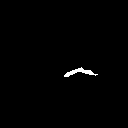

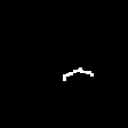

Median IOU:  0.44808743169398907


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

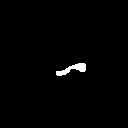

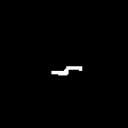

Median IOU:  0.4482758620689655


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

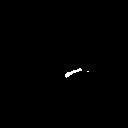

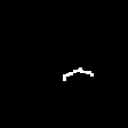

Median IOU:  0.2358490566037736


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

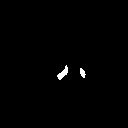

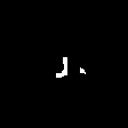

Median IOU:  0.41630901287553645


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

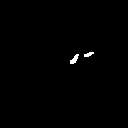

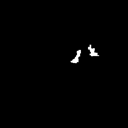

Median IOU:  0.42452830188679247


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

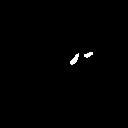

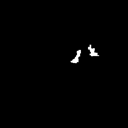

Median IOU:  0.3981042654028436


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

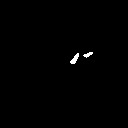

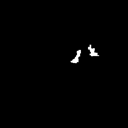

Median IOU:  0.38308457711442784


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

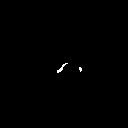

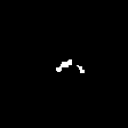

Median IOU:  0.24154589371980675


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

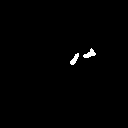

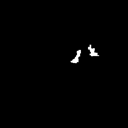

Median IOU:  0.42473118279569894


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

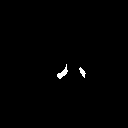

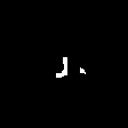

Median IOU:  0.4504950495049505


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

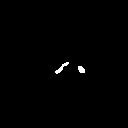

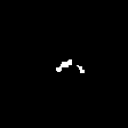

Median IOU:  0.4195121951219512


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

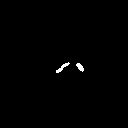

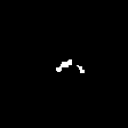

Median IOU:  0.38144329896907214


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

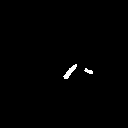

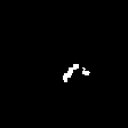

Median IOU:  0.46994535519125685


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

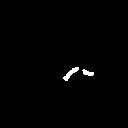

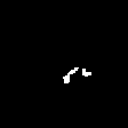

Median IOU:  0.4540540540540541


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

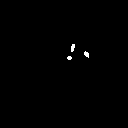

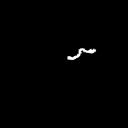

Median IOU:  0.42410714285714285


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

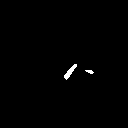

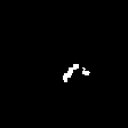

Median IOU:  0.41530054644808745


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

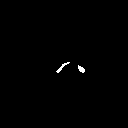

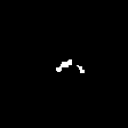

Median IOU:  0.3939393939393939


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

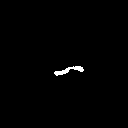

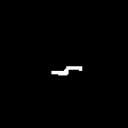

Median IOU:  0.3744292237442922


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

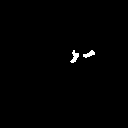

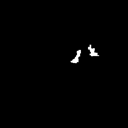

Median IOU:  0.36574074074074076


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

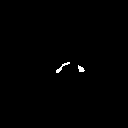

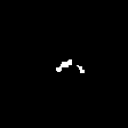

Median IOU:  0.38181818181818183


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

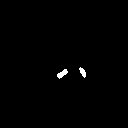

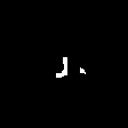

Median IOU:  0.43137254901960786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

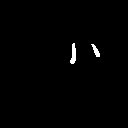

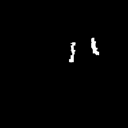

Median IOU:  0.43564356435643564


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

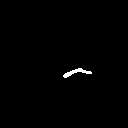

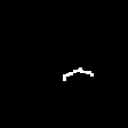

Median IOU:  0.41414141414141414


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

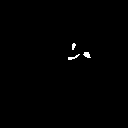

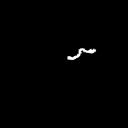

Median IOU:  0.405


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

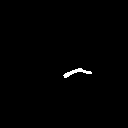

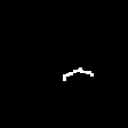

Median IOU:  0.4292929292929293


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

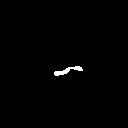

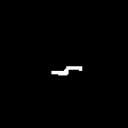

Median IOU:  0.4221105527638191


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

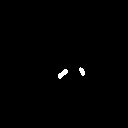

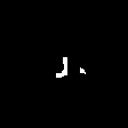

Median IOU:  0.4120603015075377


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

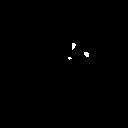

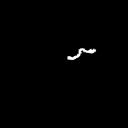

Median IOU:  0.3869346733668342


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

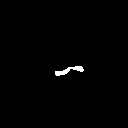

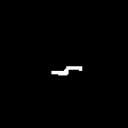

Median IOU:  0.44221105527638194


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

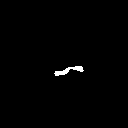

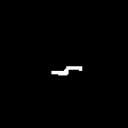

Median IOU:  0.4090909090909091


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

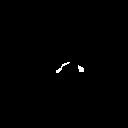

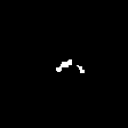

Median IOU:  0.4018264840182648


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

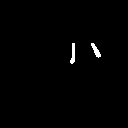

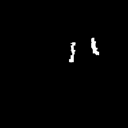

Median IOU:  0.4020100502512563


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

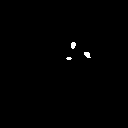

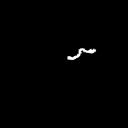

Median IOU:  0.4246575342465753


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

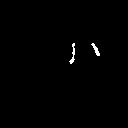

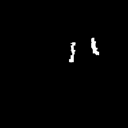

Median IOU:  0.33505154639175255


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

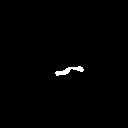

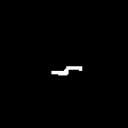

Median IOU:  0.45698924731182794


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

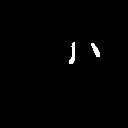

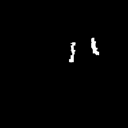

Median IOU:  0.42934782608695654


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

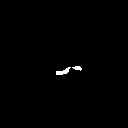

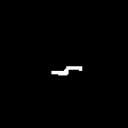

Median IOU:  0.3983050847457627


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

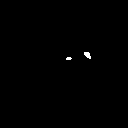

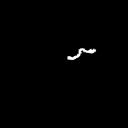

Median IOU:  0.452914798206278


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

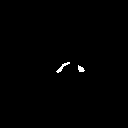

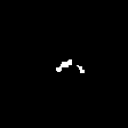

Median IOU:  0.4010989010989011


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

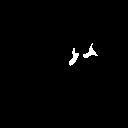

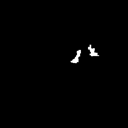

Median IOU:  0.4072164948453608


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

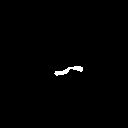

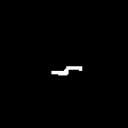

Median IOU:  0.4092827004219409


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

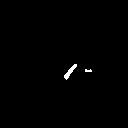

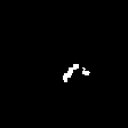

Median IOU:  0.4230769230769231


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

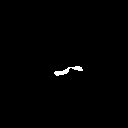

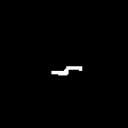

Median IOU:  0.4801762114537445


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

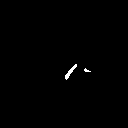

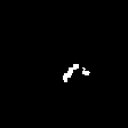

Median IOU:  0.3384615384615385


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

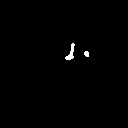

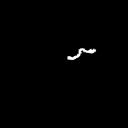

Median IOU:  0.4635416666666667


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

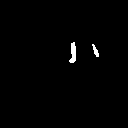

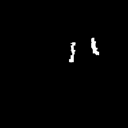

Median IOU:  0.43564356435643564


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

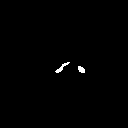

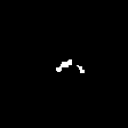

Median IOU:  0.4603960396039604


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

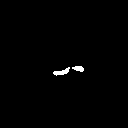

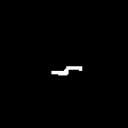

Median IOU:  0.42574257425742573


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

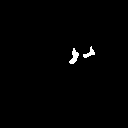

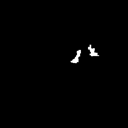

Median IOU:  0.39800995024875624


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

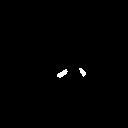

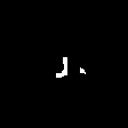

Median IOU:  0.4020100502512563


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

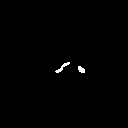

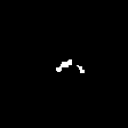

Median IOU:  0.42162162162162165


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

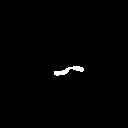

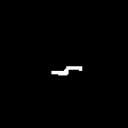

Median IOU:  0.4098360655737705


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

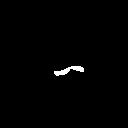

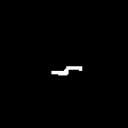

Median IOU:  0.42391304347826086


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

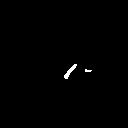

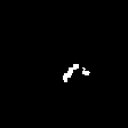

Median IOU:  0.3867403314917127


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

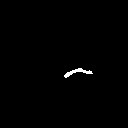

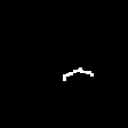

Median IOU:  0.3701657458563536


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

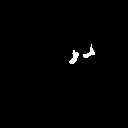

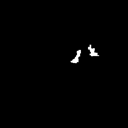

Median IOU:  0.42391304347826086


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

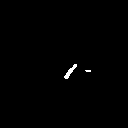

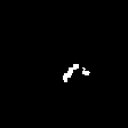

Median IOU:  0.3901098901098901


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

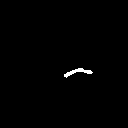

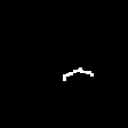

Median IOU:  0.39226519337016574


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

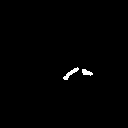

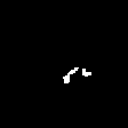

Median IOU:  0.4076086956521739


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

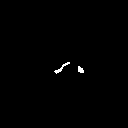

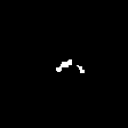

Median IOU:  0.397196261682243


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

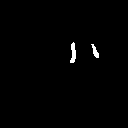

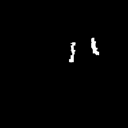

Median IOU:  0.42702702702702705


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

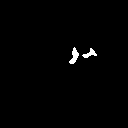

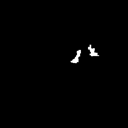

Median IOU:  0.42391304347826086


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

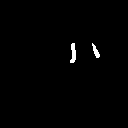

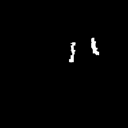

Median IOU:  0.4371584699453552


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

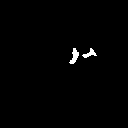

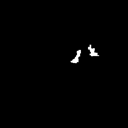

Median IOU:  0.4065934065934066


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

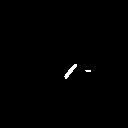

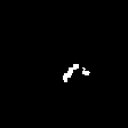

Median IOU:  0.41208791208791207


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

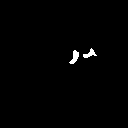

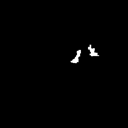

Median IOU:  0.4065934065934066


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

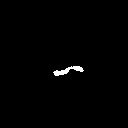

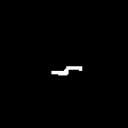

Median IOU:  0.4340659340659341


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

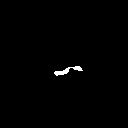

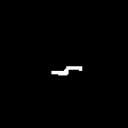

Median IOU:  0.39226519337016574


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

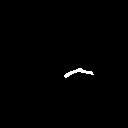

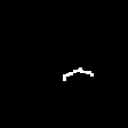

Median IOU:  0.39779005524861877


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

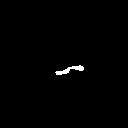

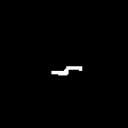

Median IOU:  0.37037037037037035


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

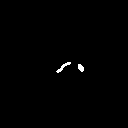

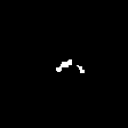

Median IOU:  0.3862433862433862


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

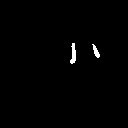

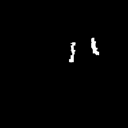

Median IOU:  0.4246575342465753


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

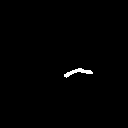

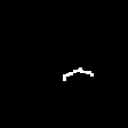

Median IOU:  0.4205128205128205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

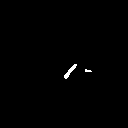

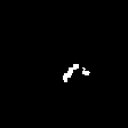

Median IOU:  0.3967391304347826


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

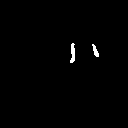

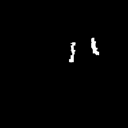

Median IOU:  0.3551912568306011


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

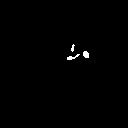

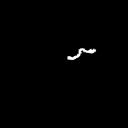

Median IOU:  0.40437158469945356


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

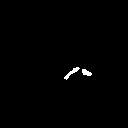

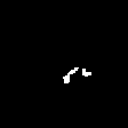

Median IOU:  0.4098360655737705


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

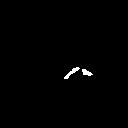

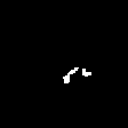

Median IOU:  0.38235294117647056


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

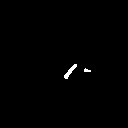

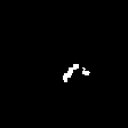

Median IOU:  0.39086294416243655


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

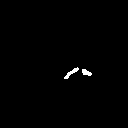

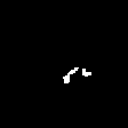

Median IOU:  0.405982905982906


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

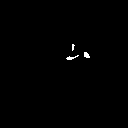

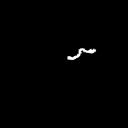

Median IOU:  0.4155251141552511


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

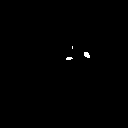

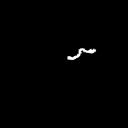

Median IOU:  0.39086294416243655


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

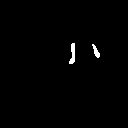

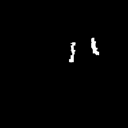

Median IOU:  0.4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

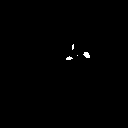

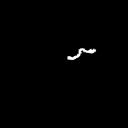

Median IOU:  0.38461538461538464


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

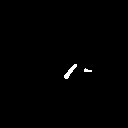

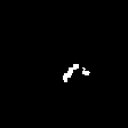

Median IOU:  0.3944954128440367


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

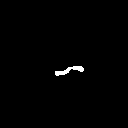

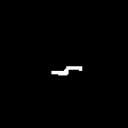

Median IOU:  0.4230769230769231


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

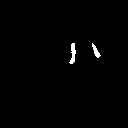

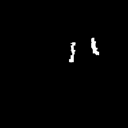

Median IOU:  0.42916666666666664


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

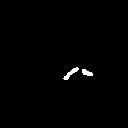

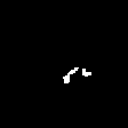

Median IOU:  0.4266666666666667


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

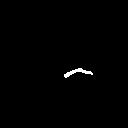

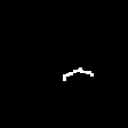

Median IOU:  0.4246575342465753


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

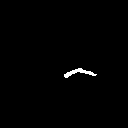

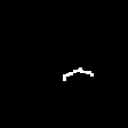

Median IOU:  0.43783783783783786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

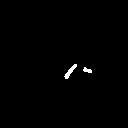

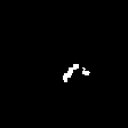

Median IOU:  0.42857142857142855


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

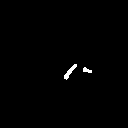

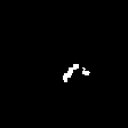

Median IOU:  0.43243243243243246


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

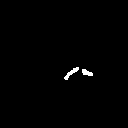

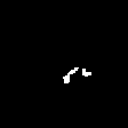

Median IOU:  0.42410714285714285


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

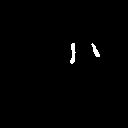

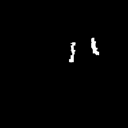

Median IOU:  0.4170403587443946


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

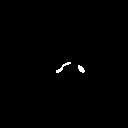

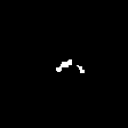

Median IOU:  0.41304347826086957


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

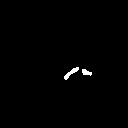

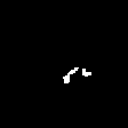

Median IOU:  0.4256410256410256


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

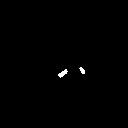

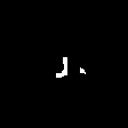

Median IOU:  0.39344262295081966


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

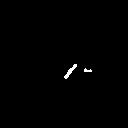

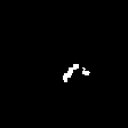

Median IOU:  0.35944700460829493


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

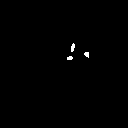

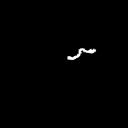

Median IOU:  0.42162162162162165


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

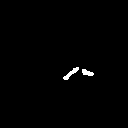

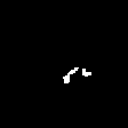

Median IOU:  0.45652173913043476


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

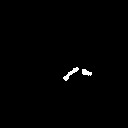

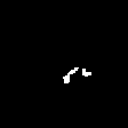

Median IOU:  0.44954128440366975


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

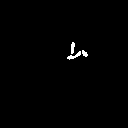

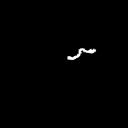

Median IOU:  0.3772893772893773


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

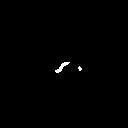

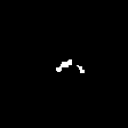

Median IOU:  0.386046511627907


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

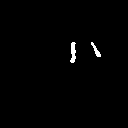

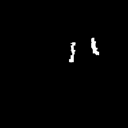

Median IOU:  0.4727272727272727


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

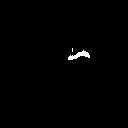

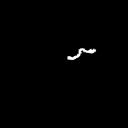

Median IOU:  0.4919786096256685


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

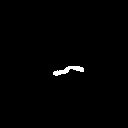

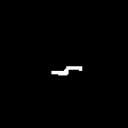

Median IOU:  0.5163043478260869


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

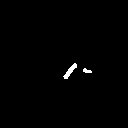

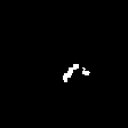

Median IOU:  0.5027322404371585


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

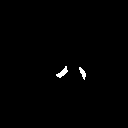

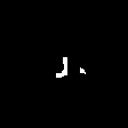

Median IOU:  0.4423076923076923


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

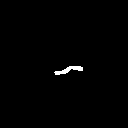

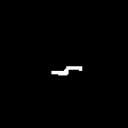

Median IOU:  0.4585635359116022


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

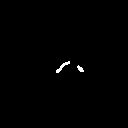

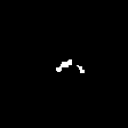

Median IOU:  0.4198895027624309


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

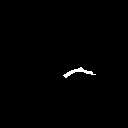

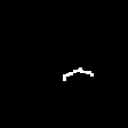

Median IOU:  0.475


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

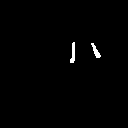

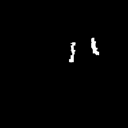

Median IOU:  0.445


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

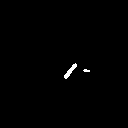

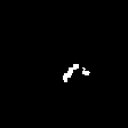

Median IOU:  0.4444444444444444


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

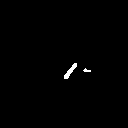

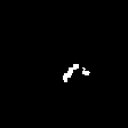

Median IOU:  0.4630541871921182


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

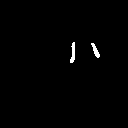

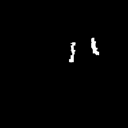

Median IOU:  0.47


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

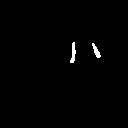

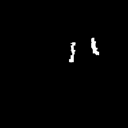

Median IOU:  0.453551912568306


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

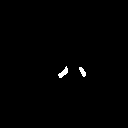

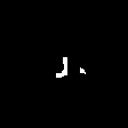

Median IOU:  0.45604395604395603


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

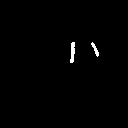

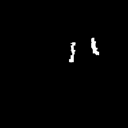

Median IOU:  0.4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

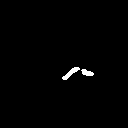

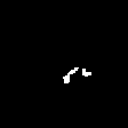

Median IOU:  0.5315315315315315


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

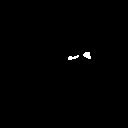

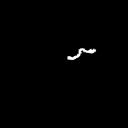

Median IOU:  0.45789473684210524


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

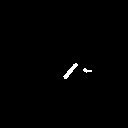

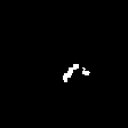

Median IOU:  0.44505494505494503


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

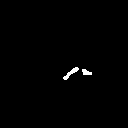

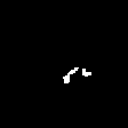

Median IOU:  0.42934782608695654


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

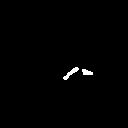

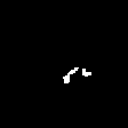

Median IOU:  0.47282608695652173


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

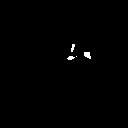

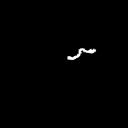

Median IOU:  0.4405940594059406


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

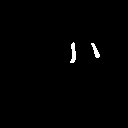

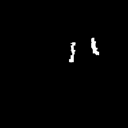

Median IOU:  0.4673913043478261


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

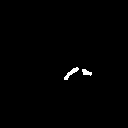

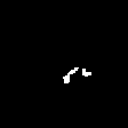

Median IOU:  0.4482758620689655


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

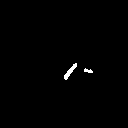

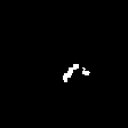

Median IOU:  0.46798029556650245


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

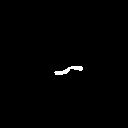

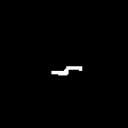

Median IOU:  0.43349753694581283


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

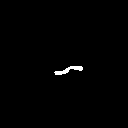

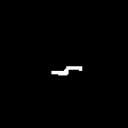

Median IOU:  0.42718446601941745


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

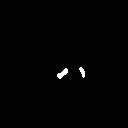

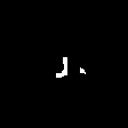

Median IOU:  0.44808743169398907


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

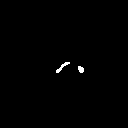

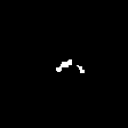

Median IOU:  0.4474885844748858


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

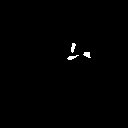

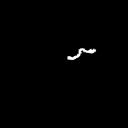

Median IOU:  0.44954128440366975


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

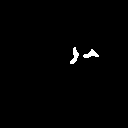

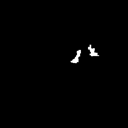

Median IOU:  0.4520547945205479


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

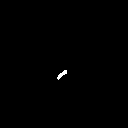

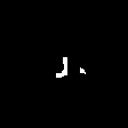

Median IOU:  0.19387755102040816


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

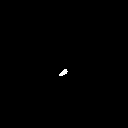

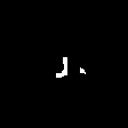

Median IOU:  0.19230769230769232


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

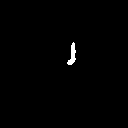

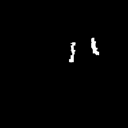

Median IOU:  0.3691588785046729


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

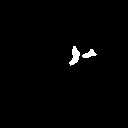

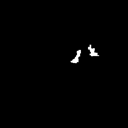

Median IOU:  0.4065040650406504


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

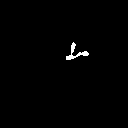

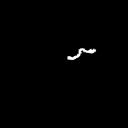

Median IOU:  0.4692982456140351


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

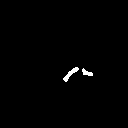

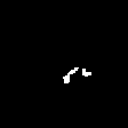

Median IOU:  0.4642857142857143


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

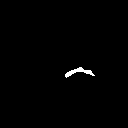

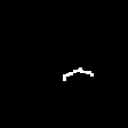

Median IOU:  0.4794520547945205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

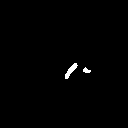

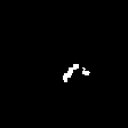

Median IOU:  0.4772727272727273


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

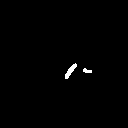

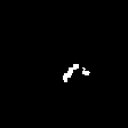

Median IOU:  0.4590909090909091


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

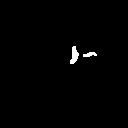

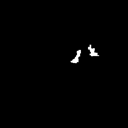

Median IOU:  0.3972602739726027


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

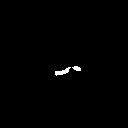

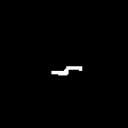

Median IOU:  0.42201834862385323


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

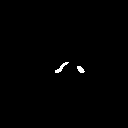

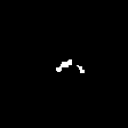

Median IOU:  0.43010752688172044


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

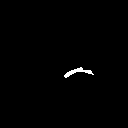

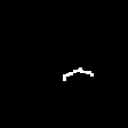

Median IOU:  0.4603960396039604


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

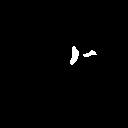

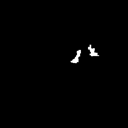

Median IOU:  0.4540540540540541


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

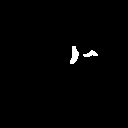

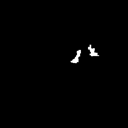

Median IOU:  0.41284403669724773


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

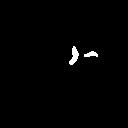

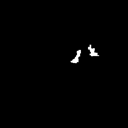

Median IOU:  0.4158415841584158


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

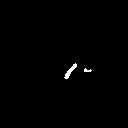

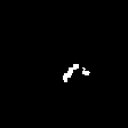

Median IOU:  0.391705069124424


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

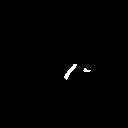

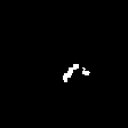

Median IOU:  0.386046511627907


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

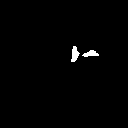

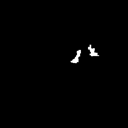

Median IOU:  0.42016806722689076


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

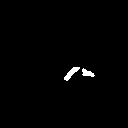

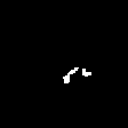

Median IOU:  0.4789915966386555


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

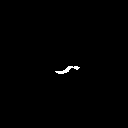

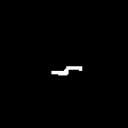

Median IOU:  0.2696629213483146


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

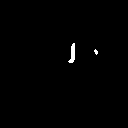

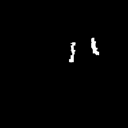

Median IOU:  0.400990099009901


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

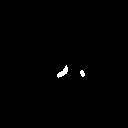

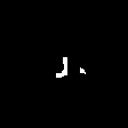

Median IOU:  0.3891625615763547


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

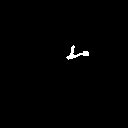

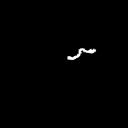

Median IOU:  0.5223880597014925


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

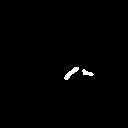

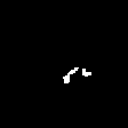

Median IOU:  0.478494623655914


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

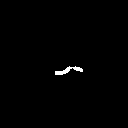

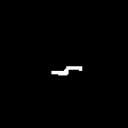

Median IOU:  0.45161290322580644


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

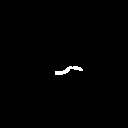

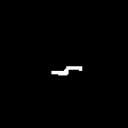

Median IOU:  0.45454545454545453


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

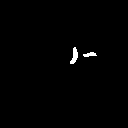

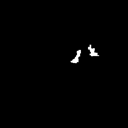

Median IOU:  0.4018264840182648


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

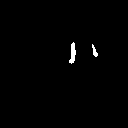

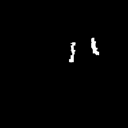

Median IOU:  0.4306930693069307


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

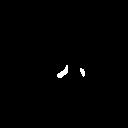

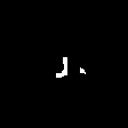

Median IOU:  0.4623115577889447


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

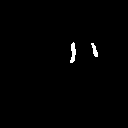

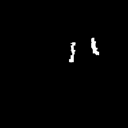

Median IOU:  0.4467005076142132


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

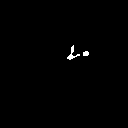

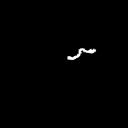

Median IOU:  0.43119266055045874


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

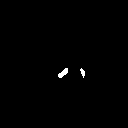

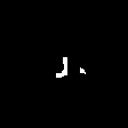

Median IOU:  0.4036697247706422


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

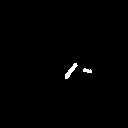

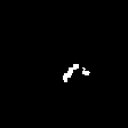

Median IOU:  0.45248868778280543


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

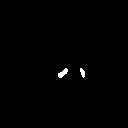

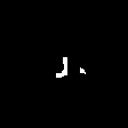

Median IOU:  0.3972602739726027


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

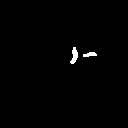

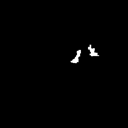

Median IOU:  0.3881278538812785


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

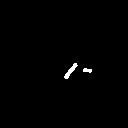

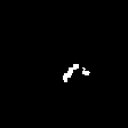

Median IOU:  0.43946188340807174


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

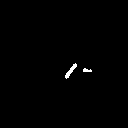

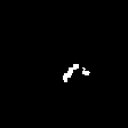

Median IOU:  0.3835616438356164


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

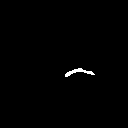

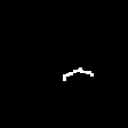

Median IOU:  0.3835616438356164


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

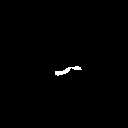

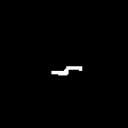

Median IOU:  0.4090909090909091


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

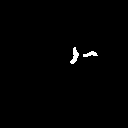

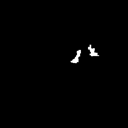

Median IOU:  0.40217391304347827


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

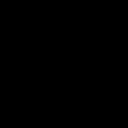

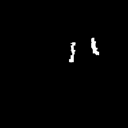

Median IOU:  0.0


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

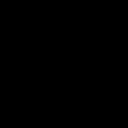

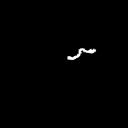

Median IOU:  0.031088082901554404


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

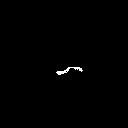

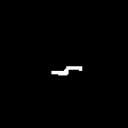

Median IOU:  0.29608938547486036


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

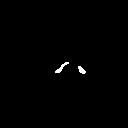

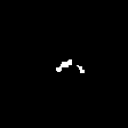

Median IOU:  0.4052863436123348


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

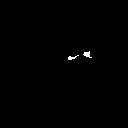

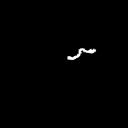

Median IOU:  0.41517857142857145


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

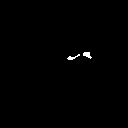

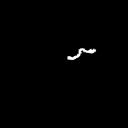

Median IOU:  0.410958904109589


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

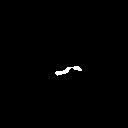

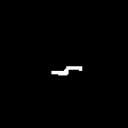

Median IOU:  0.4021164021164021


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

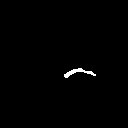

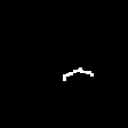

Median IOU:  0.4366812227074236


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

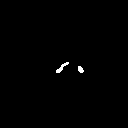

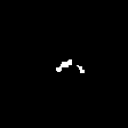

Median IOU:  0.4076086956521739


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

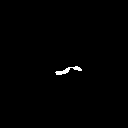

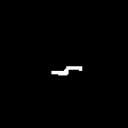

Median IOU:  0.4266666666666667


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

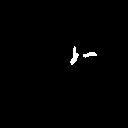

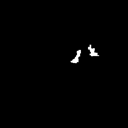

Median IOU:  0.4330357142857143


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

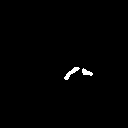

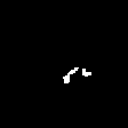

Median IOU:  0.4304932735426009


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

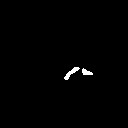

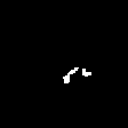

Median IOU:  0.4439461883408072


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

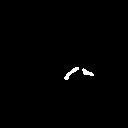

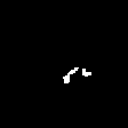

Median IOU:  0.39823008849557523


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

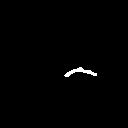

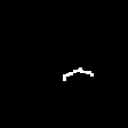

Median IOU:  0.4458874458874459


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

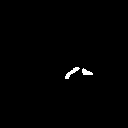

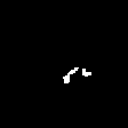

Median IOU:  0.4099099099099099


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

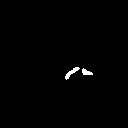

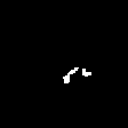

Median IOU:  0.415929203539823


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

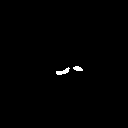

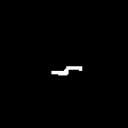

Median IOU:  0.41228070175438597


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

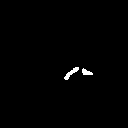

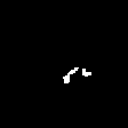

Median IOU:  0.44594594594594594


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

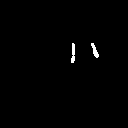

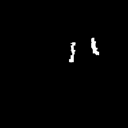

Median IOU:  0.39351851851851855


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

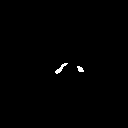

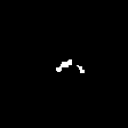

Median IOU:  0.4337899543378995


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

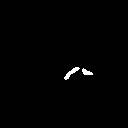

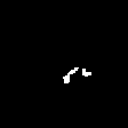

Median IOU:  0.4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

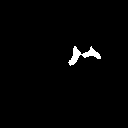

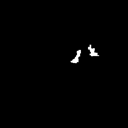

Median IOU:  0.4781021897810219


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

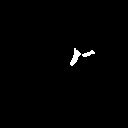

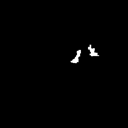

Median IOU:  0.41798941798941797


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

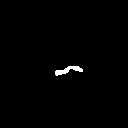

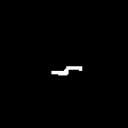

Median IOU:  0.47540983606557374


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

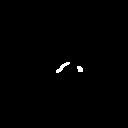

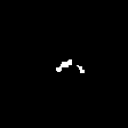

Median IOU:  0.4393305439330544


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

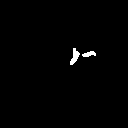

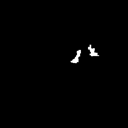

Median IOU:  0.4520547945205479


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

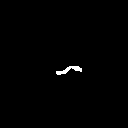

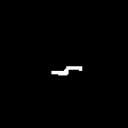

Median IOU:  0.43783783783783786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

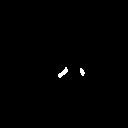

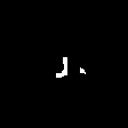

Median IOU:  0.4166666666666667


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

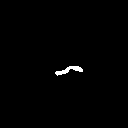

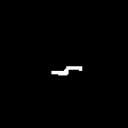

Median IOU:  0.45045045045045046


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

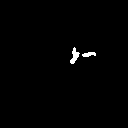

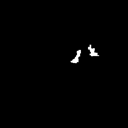

Median IOU:  0.44324324324324327


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

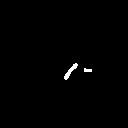

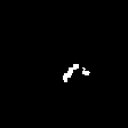

Median IOU:  0.44919786096256686


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

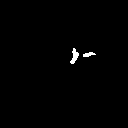

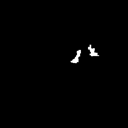

Median IOU:  0.41847826086956524


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

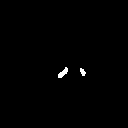

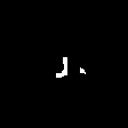

Median IOU:  0.43478260869565216


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

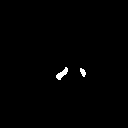

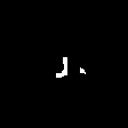

Median IOU:  0.4868421052631579


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

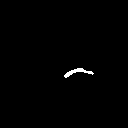

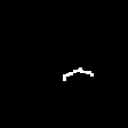

Median IOU:  0.4343891402714932


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

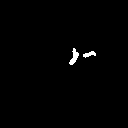

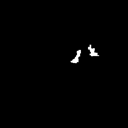

Median IOU:  0.452914798206278


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

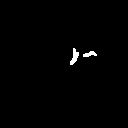

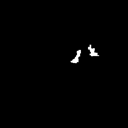

Median IOU:  0.4349775784753363


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

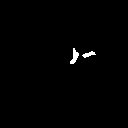

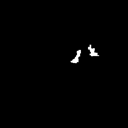

Median IOU:  0.42342342342342343


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

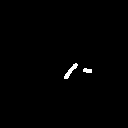

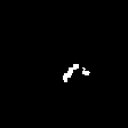

Median IOU:  0.45089285714285715


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

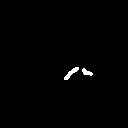

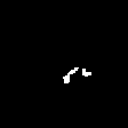

Median IOU:  0.4371859296482412


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

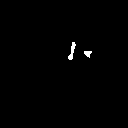

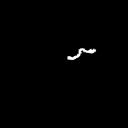

Median IOU:  0.47619047619047616


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

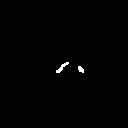

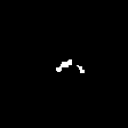

Median IOU:  0.4098360655737705


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

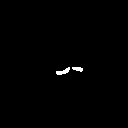

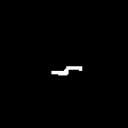

Median IOU:  0.41304347826086957


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

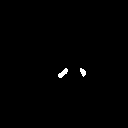

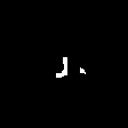

Median IOU:  0.44680851063829785


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

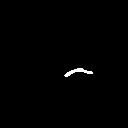

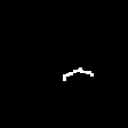

Median IOU:  0.42780748663101603


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

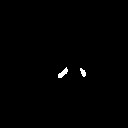

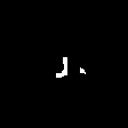

Median IOU:  0.4292237442922374


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

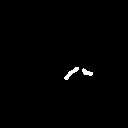

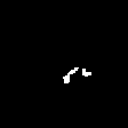

Median IOU:  0.42391304347826086


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

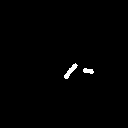

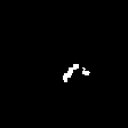

Median IOU:  0.48677248677248675


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

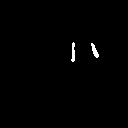

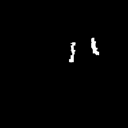

Median IOU:  0.3407821229050279


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

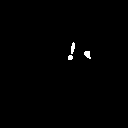

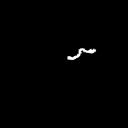

Median IOU:  0.45989304812834225


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

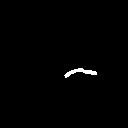

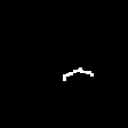

Median IOU:  0.45698924731182794


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

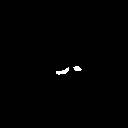

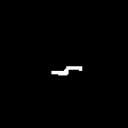

Median IOU:  0.4076086956521739


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

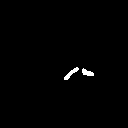

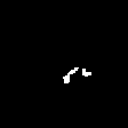

Median IOU:  0.4627659574468085


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

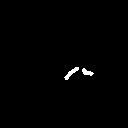

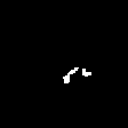

Median IOU:  0.42391304347826086


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

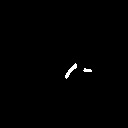

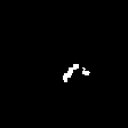

Median IOU:  0.4098360655737705


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

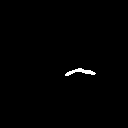

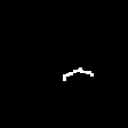

Median IOU:  0.42391304347826086


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

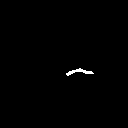

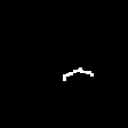

Median IOU:  0.3956043956043956


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

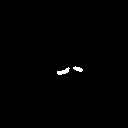

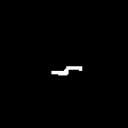

Median IOU:  0.42162162162162165


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

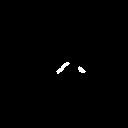

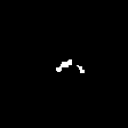

Median IOU:  0.42328042328042326


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

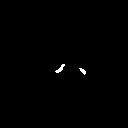

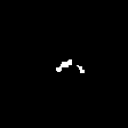

Median IOU:  0.3888888888888889


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

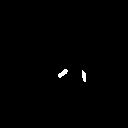

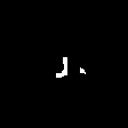

Median IOU:  0.3253588516746411


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

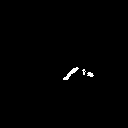

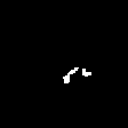

Median IOU:  0.40825688073394495


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

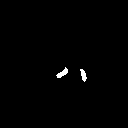

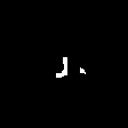

Median IOU:  0.4698275862068966


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

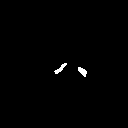

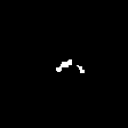

Median IOU:  0.4956896551724138


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

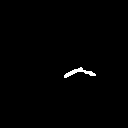

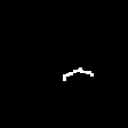

Median IOU:  0.48034934497816595


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

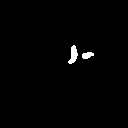

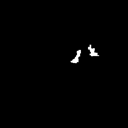

Median IOU:  0.522633744855967


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

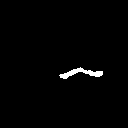

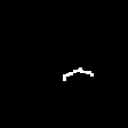

Median IOU:  0.42704626334519574


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

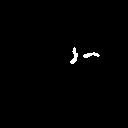

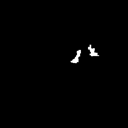

Median IOU:  0.41228070175438597


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

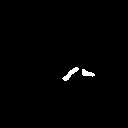

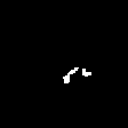

Median IOU:  0.49572649572649574


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

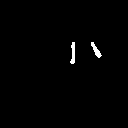

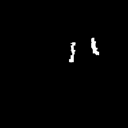

Median IOU:  0.4692982456140351


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

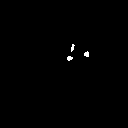

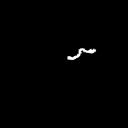

Median IOU:  0.4759825327510917


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

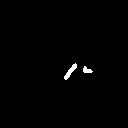

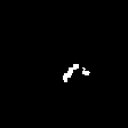

Median IOU:  0.47161572052401746


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

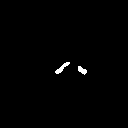

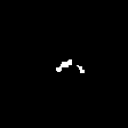

Median IOU:  0.49344978165938863


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

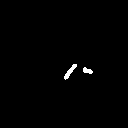

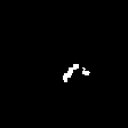

Median IOU:  0.45614035087719296


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

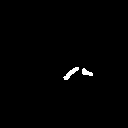

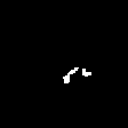

Median IOU:  0.47345132743362833


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

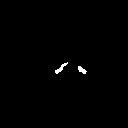

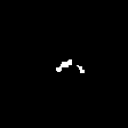

Median IOU:  0.4336283185840708


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

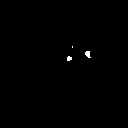

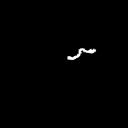

Median IOU:  0.4652173913043478


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

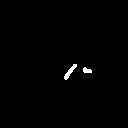

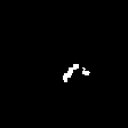

Median IOU:  0.45535714285714285


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

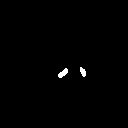

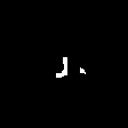

Median IOU:  0.462882096069869


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

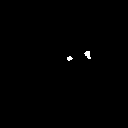

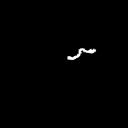

Median IOU:  0.4669603524229075


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

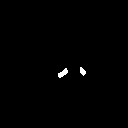

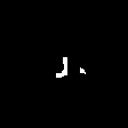

Median IOU:  0.45089285714285715


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

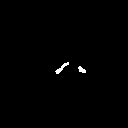

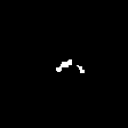

Median IOU:  0.44298245614035087


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

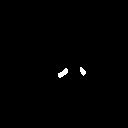

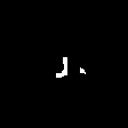

Median IOU:  0.45374449339207046


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

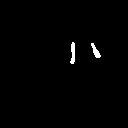

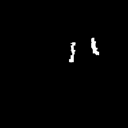

Median IOU:  0.4424778761061947


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

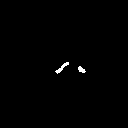

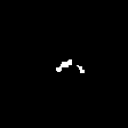

Median IOU:  0.41935483870967744


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

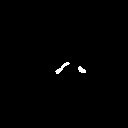

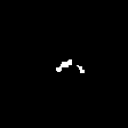

Median IOU:  0.4473684210526316


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

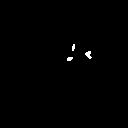

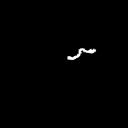

Median IOU:  0.45021645021645024


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

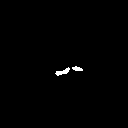

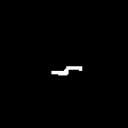

Median IOU:  0.39896373056994816


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

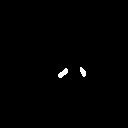

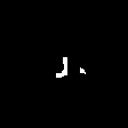

Median IOU:  0.44493392070484583


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

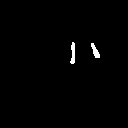

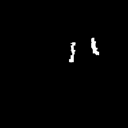

Median IOU:  0.4469026548672566


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

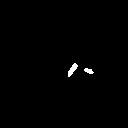

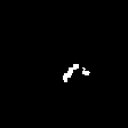

Median IOU:  0.3706896551724138


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

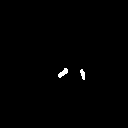

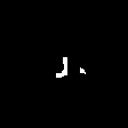

Median IOU:  0.33649289099526064


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

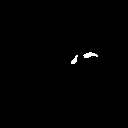

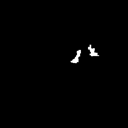

Median IOU:  0.35960591133004927


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

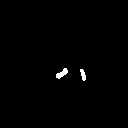

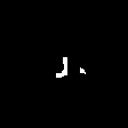

Median IOU:  0.43568464730290457


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

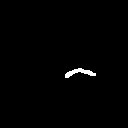

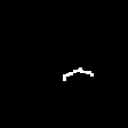

Median IOU:  0.39814814814814814


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

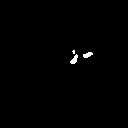

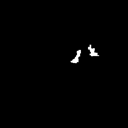

Median IOU:  0.38636363636363635


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

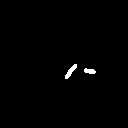

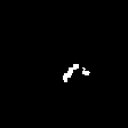

Median IOU:  0.4024896265560166


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

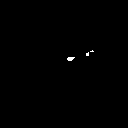

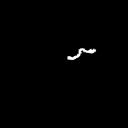

Median IOU:  0.4391304347826087


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

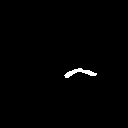

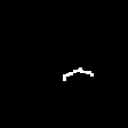

Median IOU:  0.44052863436123346


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

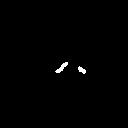

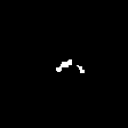

Median IOU:  0.43915343915343913


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

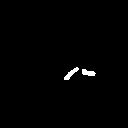

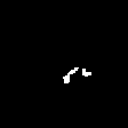

Median IOU:  0.4421052631578947


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

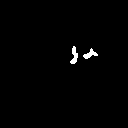

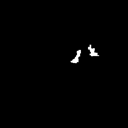

Median IOU:  0.4368421052631579


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

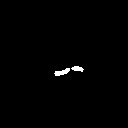

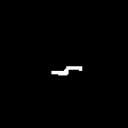

Median IOU:  0.4406779661016949


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

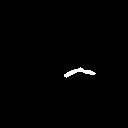

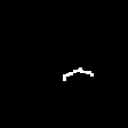

Median IOU:  0.46236559139784944


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

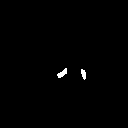

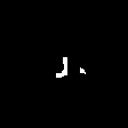

Median IOU:  0.4385026737967914


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

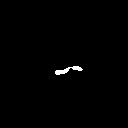

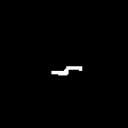

Median IOU:  0.43783783783783786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

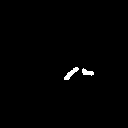

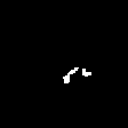

Median IOU:  0.43548387096774194


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

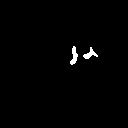

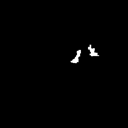

Median IOU:  0.43478260869565216


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

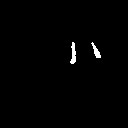

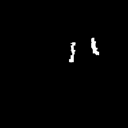

Median IOU:  0.44086021505376344


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

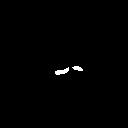

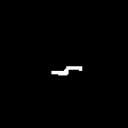

Median IOU:  0.43478260869565216


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

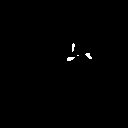

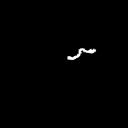

Median IOU:  0.43783783783783786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

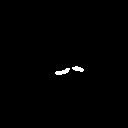

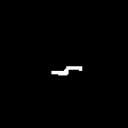

Median IOU:  0.44623655913978494


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

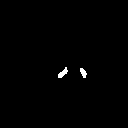

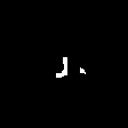

Median IOU:  0.4540540540540541


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

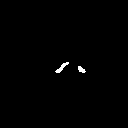

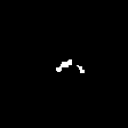

Median IOU:  0.44324324324324327


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

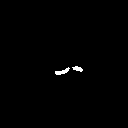

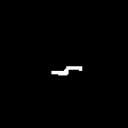

Median IOU:  0.41847826086956524


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

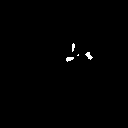

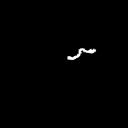

Median IOU:  0.43783783783783786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

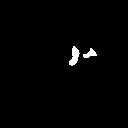

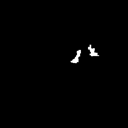

Median IOU:  0.46320346320346323


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

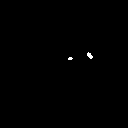

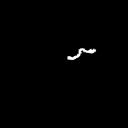

Median IOU:  0.4009216589861751


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

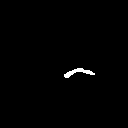

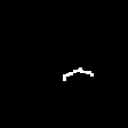

Median IOU:  0.45614035087719296


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

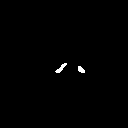

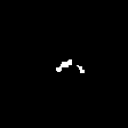

Median IOU:  0.4366812227074236


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

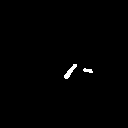

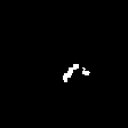

Median IOU:  0.4222222222222222


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

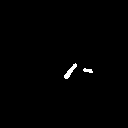

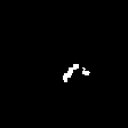

Median IOU:  0.4266666666666667


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

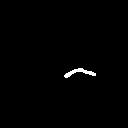

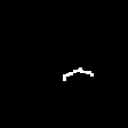

Median IOU:  0.4458874458874459


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

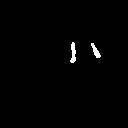

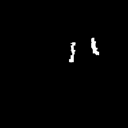

Median IOU:  0.4148471615720524


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

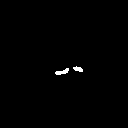

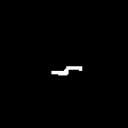

Median IOU:  0.43478260869565216


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

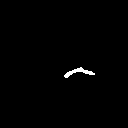

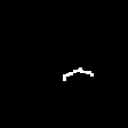

Median IOU:  0.4298245614035088


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

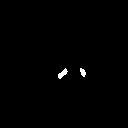

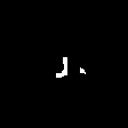

Median IOU:  0.4298245614035088


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

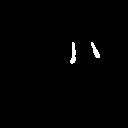

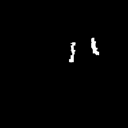

Median IOU:  0.44052863436123346


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

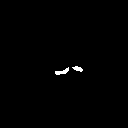

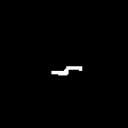

Median IOU:  0.42920353982300885


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

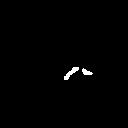

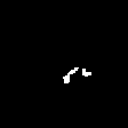

Median IOU:  0.44


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

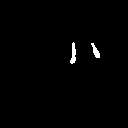

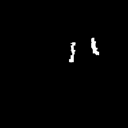

Median IOU:  0.44298245614035087


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

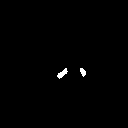

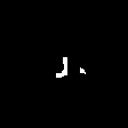

Median IOU:  0.42


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

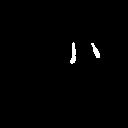

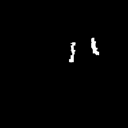

Median IOU:  0.4192139737991266


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

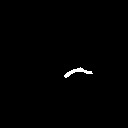

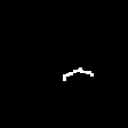

Median IOU:  0.4247787610619469


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

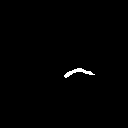

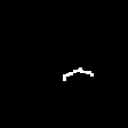

Median IOU:  0.4185022026431718


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

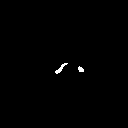

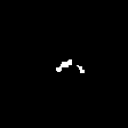

Median IOU:  0.41150442477876104


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

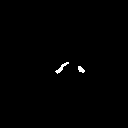

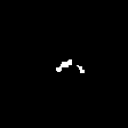

Median IOU:  0.42105263157894735


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

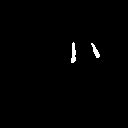

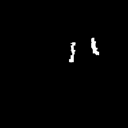

Median IOU:  0.4330357142857143


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

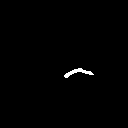

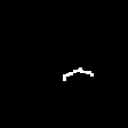

Median IOU:  0.4375


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

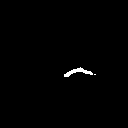

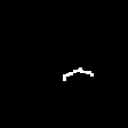

Median IOU:  0.42731277533039647


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

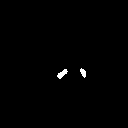

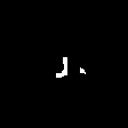

Median IOU:  0.42543859649122806


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

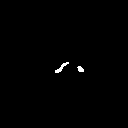

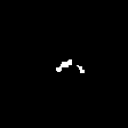

Median IOU:  0.42731277533039647


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

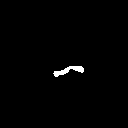

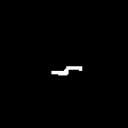

Median IOU:  0.4818181818181818


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

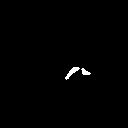

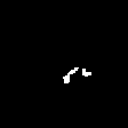

Median IOU:  0.40414507772020725


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

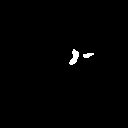

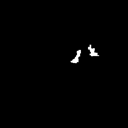

Median IOU:  0.4626865671641791


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.6181102362204725


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

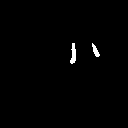

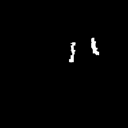

Median IOU:  0.4619289340101523


In [76]:
# criterion
device = torch.device('cuda')
model = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)

#model.load_state_dict(torch.load('best_model_unet_nobo_64.pth'))
#model.load_state_dict(torch.load('best_model_unet_nobo_64_more_blocks.pth'))
model.load_state_dict(torch.load('best_model_unet_nobo_128_thirtyeighth_bis.pth'))

#criterion = torch.nn.CrossEntropyLoss(reduction='none')
criterion = torch.nn.BCELoss(weight = torch.Tensor([1]).cuda())

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  validation_names = eval_ds.names,
                  lr_scheduler=torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.999),
                  epochs=500,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

0


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

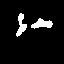

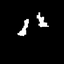

Median IOU:  0.40298507462686567
saved with score:  0.40298507462686567


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.40298507462686567


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

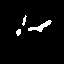

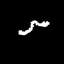

Median IOU:  0.3858695652173913


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.40298507462686567


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

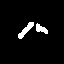

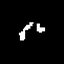

Median IOU:  0.39502762430939226


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.40298507462686567


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

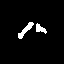

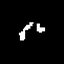

Median IOU:  0.3739612188365651


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.40298507462686567


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

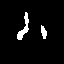

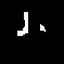

Median IOU:  0.42528735632183906
saved with score:  0.42528735632183906


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

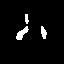

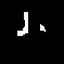

Median IOU:  0.3646723646723647


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

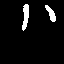

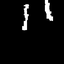

Median IOU:  0.3732394366197183


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

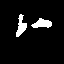

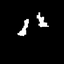

Median IOU:  0.3564954682779456


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

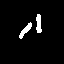

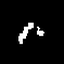

Median IOU:  0.38


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

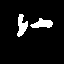

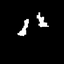

Median IOU:  0.39156626506024095


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

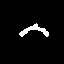

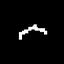

Median IOU:  0.3926940639269406


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

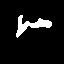

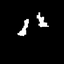

Median IOU:  0.3884057971014493


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

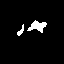

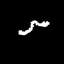

Median IOU:  0.37


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

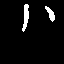

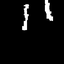

Median IOU:  0.3768844221105528


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

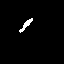

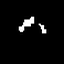

Median IOU:  0.38388625592417064


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

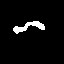

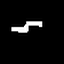

Median IOU:  0.38425925925925924


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

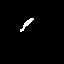

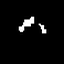

Median IOU:  0.3904109589041096


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

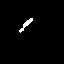

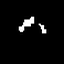

Median IOU:  0.39090909090909093


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

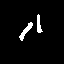

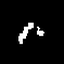

Median IOU:  0.41814159292035397


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

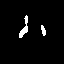

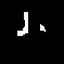

Median IOU:  0.3977272727272727


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

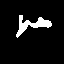

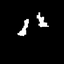

Median IOU:  0.4206896551724138


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

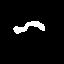

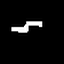

Median IOU:  0.4126984126984127


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

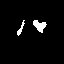

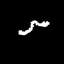

Median IOU:  0.4116279069767442


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

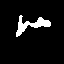

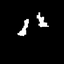

Median IOU:  0.4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

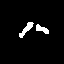

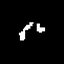

Median IOU:  0.40229885057471265


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

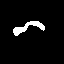

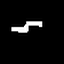

Median IOU:  0.3930232558139535


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

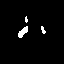

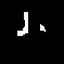

Median IOU:  0.3842696629213483


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

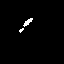

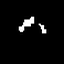

Median IOU:  0.38927738927738925


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

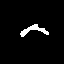

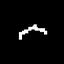

Median IOU:  0.3930232558139535


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

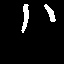

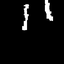

Median IOU:  0.384375


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

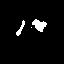

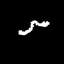

Median IOU:  0.38095238095238093


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

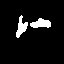

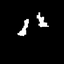

Median IOU:  0.39400921658986177


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

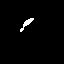

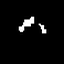

Median IOU:  0.40229885057471265


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

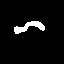

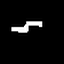

Median IOU:  0.4044943820224719


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

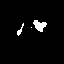

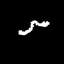

Median IOU:  0.39863325740318906


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

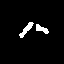

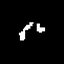

Median IOU:  0.3977272727272727


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

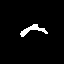

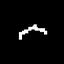

Median IOU:  0.39675174013921116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

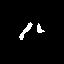

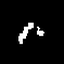

Median IOU:  0.38425925925925924


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

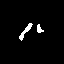

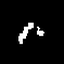

Median IOU:  0.39285714285714285


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

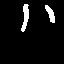

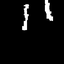

Median IOU:  0.3811764705882353


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

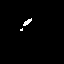

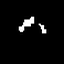

Median IOU:  0.3881278538812785


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

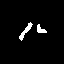

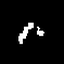

Median IOU:  0.40186915887850466


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

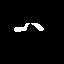

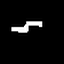

Median IOU:  0.28792569659442724


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

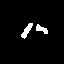

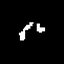

Median IOU:  0.4041994750656168


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

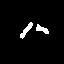

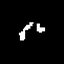

Median IOU:  0.391304347826087


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

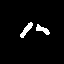

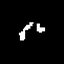

Median IOU:  0.39141414141414144


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

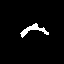

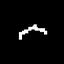

Median IOU:  0.3960880195599022


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

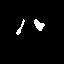

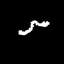

Median IOU:  0.3929471032745592


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

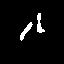

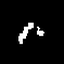

Median IOU:  0.3915211970074813


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

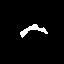

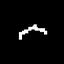

Median IOU:  0.37799043062200954


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

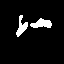

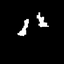

Median IOU:  0.3752913752913753


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

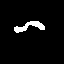

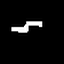

Median IOU:  0.36790123456790125


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

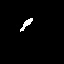

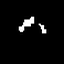

Median IOU:  0.37721518987341773


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

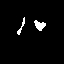

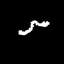

Median IOU:  0.37817258883248733


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

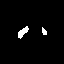

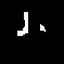

Median IOU:  0.3728813559322034


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

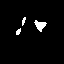

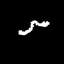

Median IOU:  0.3476190476190476


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

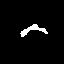

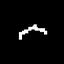

Median IOU:  0.342042755344418


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

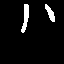

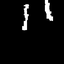

Median IOU:  0.37163814180929094


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

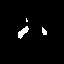

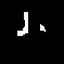

Median IOU:  0.3704600484261501


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

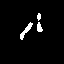

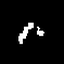

Median IOU:  0.3735224586288416


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

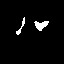

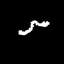

Median IOU:  0.3605769230769231


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

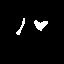

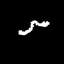

Median IOU:  0.3589108910891089


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

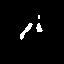

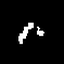

Median IOU:  0.366412213740458


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

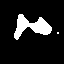

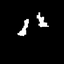

Median IOU:  0.39689922480620154


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

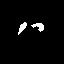

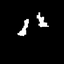

Median IOU:  0.21311475409836064


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

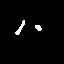

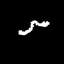

Median IOU:  0.36683417085427134


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

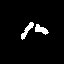

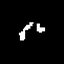

Median IOU:  0.3788659793814433


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

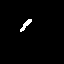

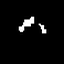

Median IOU:  0.37791932059447986


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

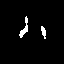

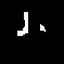

Median IOU:  0.3540772532188841


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

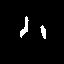

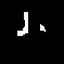

Median IOU:  0.37404580152671757


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

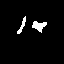

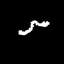

Median IOU:  0.3674832962138085


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

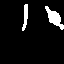

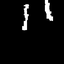

Median IOU:  0.34523809523809523


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

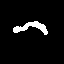

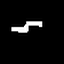

Median IOU:  0.3575


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

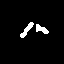

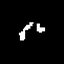

Median IOU:  0.34951456310679613


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

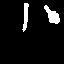

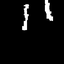

Median IOU:  0.363855421686747


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

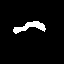

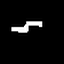

Median IOU:  0.3556085918854415


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

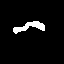

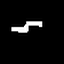

Median IOU:  0.3501199040767386


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

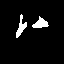

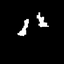

Median IOU:  0.3598014888337469


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

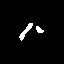

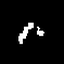

Median IOU:  0.36049382716049383


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

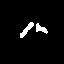

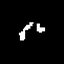

Median IOU:  0.3594132029339853


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

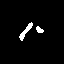

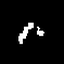

Median IOU:  0.3691931540342298


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

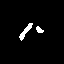

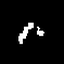

Median IOU:  0.36650485436893204


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

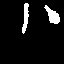

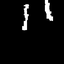

Median IOU:  0.39211136890951276


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

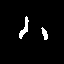

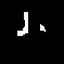

Median IOU:  0.3808411214953271


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

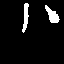

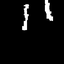

Median IOU:  0.3811764705882353


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

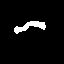

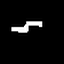

Median IOU:  0.4133949191685912


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

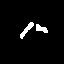

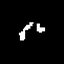

Median IOU:  0.4215456674473068


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

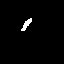

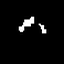

Median IOU:  0.3990498812351544


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

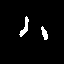

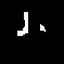

Median IOU:  0.3915094339622642


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

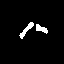

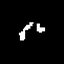

Median IOU:  0.3873239436619718


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

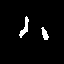

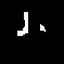

Median IOU:  0.3900709219858156


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

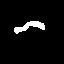

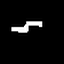

Median IOU:  0.37292161520190026


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

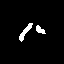

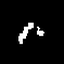

Median IOU:  0.3870967741935484


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

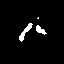

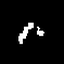

Median IOU:  0.38927738927738925


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

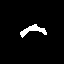

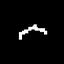

Median IOU:  0.38443396226415094


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

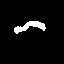

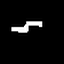

Median IOU:  0.3986175115207373


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

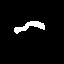

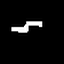

Median IOU:  0.3847980997624703


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

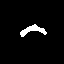

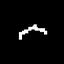

Median IOU:  0.36941176470588233


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

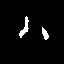

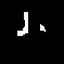

Median IOU:  0.3696682464454976


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

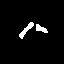

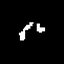

Median IOU:  0.3937947494033413


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

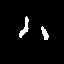

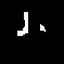

Median IOU:  0.39294117647058824


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

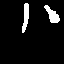

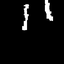

Median IOU:  0.38588235294117645


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

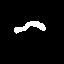

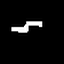

Median IOU:  0.37971698113207547


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

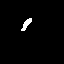

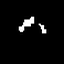

Median IOU:  0.39344262295081966


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

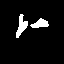

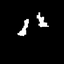

Median IOU:  0.375886524822695


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

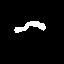

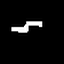

Median IOU:  0.36729857819905215


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

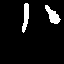

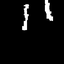

Median IOU:  0.37292161520190026


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

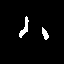

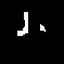

Median IOU:  0.375886524822695


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

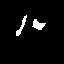

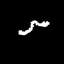

Median IOU:  0.38927738927738925


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

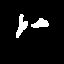

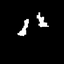

Median IOU:  0.3806146572104019


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

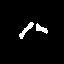

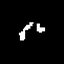

Median IOU:  0.38875878220140514


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

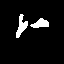

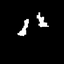

Median IOU:  0.375


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

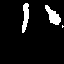

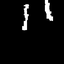

Median IOU:  0.37637362637362637


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

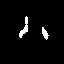

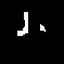

Median IOU:  0.3539325842696629


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

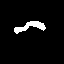

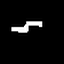

Median IOU:  0.3700564971751412


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

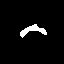

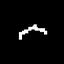

Median IOU:  0.36944444444444446


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

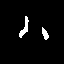

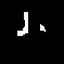

Median IOU:  0.3664302600472813


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

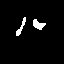

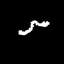

Median IOU:  0.37236533957845436


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

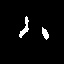

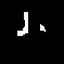

Median IOU:  0.3615023474178404


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

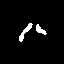

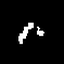

Median IOU:  0.3757062146892655


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

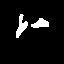

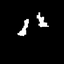

Median IOU:  0.38095238095238093


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

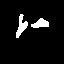

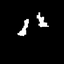

Median IOU:  0.37047353760445684


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

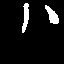

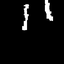

Median IOU:  0.3732590529247911


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

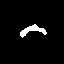

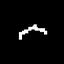

Median IOU:  0.3691588785046729


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

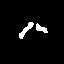

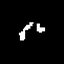

Median IOU:  0.3700234192037471


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

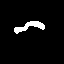

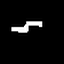

Median IOU:  0.37203791469194314


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

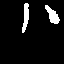

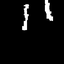

Median IOU:  0.36705882352941177


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

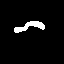

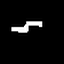

Median IOU:  0.3723150357995227


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

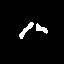

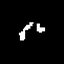

Median IOU:  0.37236533957845436


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

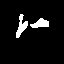

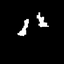

Median IOU:  0.37028301886792453


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

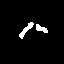

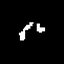

Median IOU:  0.36768149882903983


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

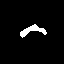

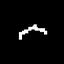

Median IOU:  0.37995337995337997


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

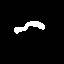

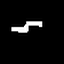

Median IOU:  0.3685446009389671


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

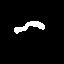

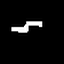

Median IOU:  0.36511627906976746


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

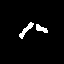

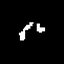

Median IOU:  0.3552941176470588


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

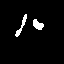

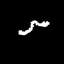

Median IOU:  0.3659217877094972


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

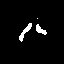

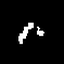

Median IOU:  0.36619718309859156


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

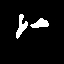

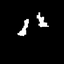

Median IOU:  0.38440111420612816


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

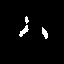

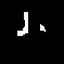

Median IOU:  0.3697478991596639


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

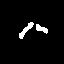

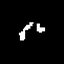

Median IOU:  0.37254901960784315


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

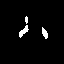

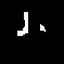

Median IOU:  0.3753501400560224


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

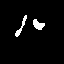

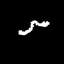

Median IOU:  0.3697478991596639


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

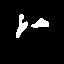

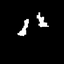

Median IOU:  0.3707865168539326


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

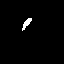

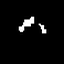

Median IOU:  0.37047353760445684


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

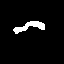

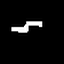

Median IOU:  0.37640449438202245


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

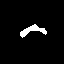

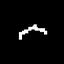

Median IOU:  0.37640449438202245


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

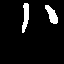

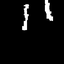

Median IOU:  0.38268156424581007


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

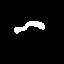

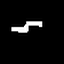

Median IOU:  0.36134453781512604


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

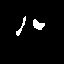

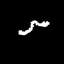

Median IOU:  0.37815126050420167


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

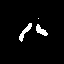

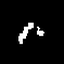

Median IOU:  0.38997214484679665


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

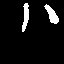

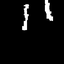

Median IOU:  0.3707865168539326


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

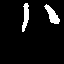

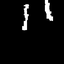

Median IOU:  0.36768802228412256


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

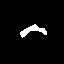

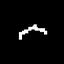

Median IOU:  0.37359550561797755


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

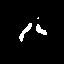

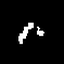

Median IOU:  0.3753501400560224


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

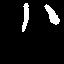

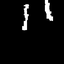

Median IOU:  0.37254901960784315


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

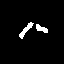

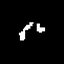

Median IOU:  0.37142857142857144


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

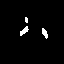

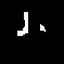

Median IOU:  0.37254901960784315


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

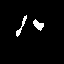

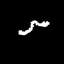

Median IOU:  0.38095238095238093


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

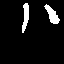

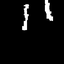

Median IOU:  0.3761904761904762


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

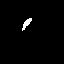

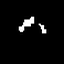

Median IOU:  0.38375350140056025


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

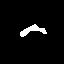

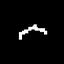

Median IOU:  0.37708830548926014


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

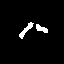

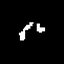

Median IOU:  0.38405797101449274


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

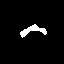

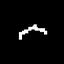

Median IOU:  0.39154929577464787


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

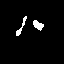

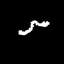

Median IOU:  0.38028169014084506


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

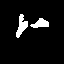

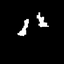

Median IOU:  0.3835294117647059


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

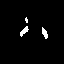

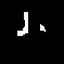

Median IOU:  0.38313253012048193


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

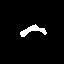

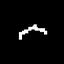

Median IOU:  0.38106796116504854


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

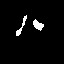

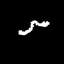

Median IOU:  0.3818615751789976


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

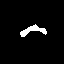

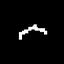

Median IOU:  0.36982968369829683


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

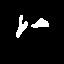

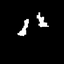

Median IOU:  0.37464788732394366


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

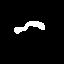

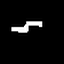

Median IOU:  0.37640449438202245


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

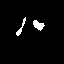

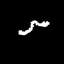

Median IOU:  0.36901408450704226


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

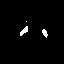

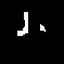

Median IOU:  0.35106382978723405


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

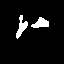

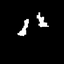

Median IOU:  0.39709443099273606


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

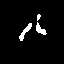

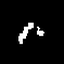

Median IOU:  0.3838383838383838


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

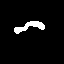

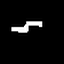

Median IOU:  0.38071065989847713


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

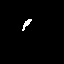

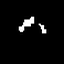

Median IOU:  0.3705103969754253


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

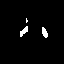

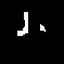

Median IOU:  0.36608863198458574


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

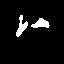

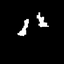

Median IOU:  0.3722627737226277


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

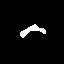

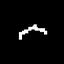

Median IOU:  0.3799019607843137


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

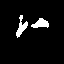

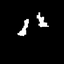

Median IOU:  0.36764705882352944


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

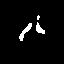

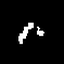

Median IOU:  0.3712871287128713


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

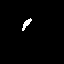

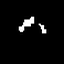

Median IOU:  0.3740648379052369


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

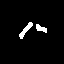

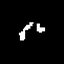

Median IOU:  0.3743718592964824


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

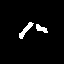

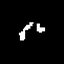

Median IOU:  0.371007371007371


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

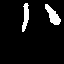

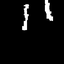

Median IOU:  0.3768844221105528


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

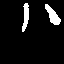

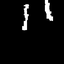

Median IOU:  0.38107416879795397


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

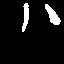

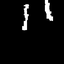

Median IOU:  0.3788659793814433


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

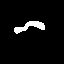

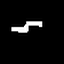

Median IOU:  0.38461538461538464


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

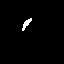

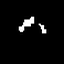

Median IOU:  0.3722627737226277


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

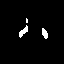

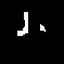

Median IOU:  0.3645320197044335


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

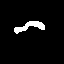

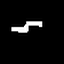

Median IOU:  0.37279596977329976


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

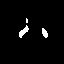

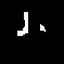

Median IOU:  0.3765586034912718


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

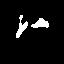

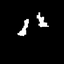

Median IOU:  0.3669950738916256


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

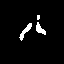

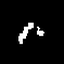

Median IOU:  0.38313253012048193


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

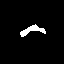

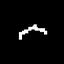

Median IOU:  0.3740831295843521


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

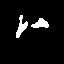

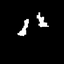

Median IOU:  0.36650485436893204


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

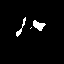

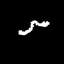

Median IOU:  0.3684210526315789


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

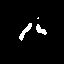

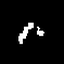

Median IOU:  0.37343358395989973


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

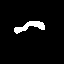

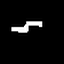

Median IOU:  0.37438423645320196


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

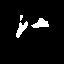

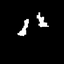

Median IOU:  0.37531486146095716


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

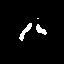

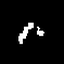

Median IOU:  0.3697478991596639


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

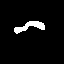

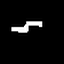

Median IOU:  0.3659217877094972


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

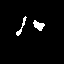

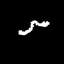

Median IOU:  0.37037037037037035


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

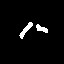

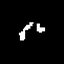

Median IOU:  0.3712871287128713


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

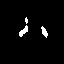

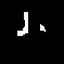

Median IOU:  0.3691931540342298


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

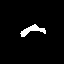

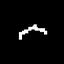

Median IOU:  0.36519607843137253


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

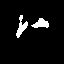

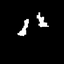

Median IOU:  0.3669950738916256


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

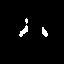

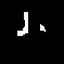

Median IOU:  0.371571072319202


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

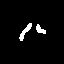

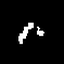

Median IOU:  0.3706467661691542


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

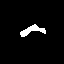

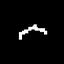

Median IOU:  0.36764705882352944


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

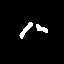

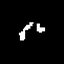

Median IOU:  0.362962962962963


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

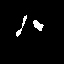

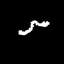

Median IOU:  0.36363636363636365


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

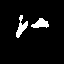

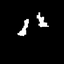

Median IOU:  0.36829268292682926


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

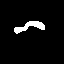

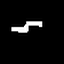

Median IOU:  0.37595907928388744


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

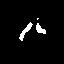

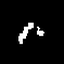

Median IOU:  0.37279596977329976


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

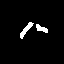

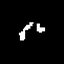

Median IOU:  0.37851662404092073


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

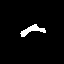

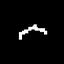

Median IOU:  0.3791348600508906


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

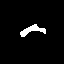

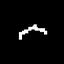

Median IOU:  0.3746898263027295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

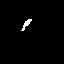

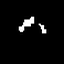

Median IOU:  0.37755102040816324


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

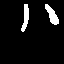

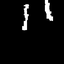

Median IOU:  0.37844611528822053


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

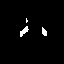

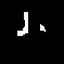

Median IOU:  0.385


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

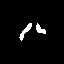

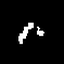

Median IOU:  0.3793969849246231


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

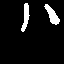

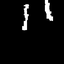

Median IOU:  0.36674816625916873


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

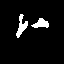

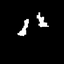

Median IOU:  0.36982968369829683


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

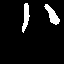

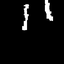

Median IOU:  0.3805970149253731


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

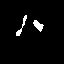

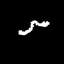

Median IOU:  0.3787878787878788


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

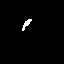

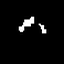

Median IOU:  0.3904282115869018


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

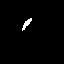

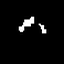

Median IOU:  0.38144329896907214


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

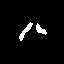

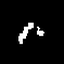

Median IOU:  0.3934010152284264


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

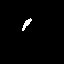

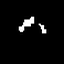

Median IOU:  0.38345864661654133


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

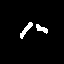

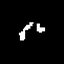

Median IOU:  0.3880208333333333


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

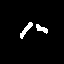

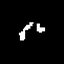

Median IOU:  0.3785900783289817


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

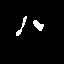

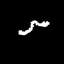

Median IOU:  0.381201044386423


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

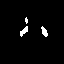

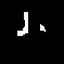

Median IOU:  0.38181818181818183


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

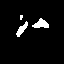

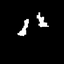

Median IOU:  0.3791208791208791


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

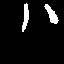

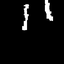

Median IOU:  0.3575268817204301


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

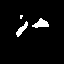

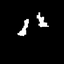

Median IOU:  0.3682795698924731


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

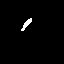

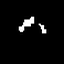

Median IOU:  0.36436170212765956


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

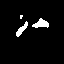

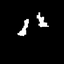

Median IOU:  0.368


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

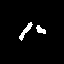

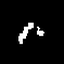

Median IOU:  0.368


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

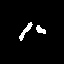

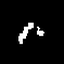

Median IOU:  0.3684210526315789


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

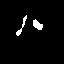

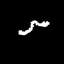

Median IOU:  0.3726541554959786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


Validation:   0%|          | 0/9 [00:00<?, ?it/s]

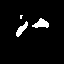

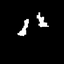

Median IOU:  0.376657824933687


Training:   0%|          | 0/19 [00:00<?, ?it/s]

0.42528735632183906


KeyboardInterrupt: 

In [30]:
# criterion
device = torch.device('cuda')
model = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)
#model.load_state_dict(torch.load('best_model_unet_nobo_64.pth'))
#model.load_state_dict(torch.load('best_model_unet_nobo_64_more_blocks.pth'))
model.load_state_dict(torch.load('best_model_unet_nobo_128_thirtythird.pth'))

#criterion = torch.nn.CrossEntropyLoss(reduction='none')
criterion = torch.nn.BCELoss(weight = torch.Tensor([1]).cuda())

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  validation_names = eval_ds.names,
                  lr_scheduler=torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.999),
                  epochs=500,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

In [75]:
round(1.6)

2

In [31]:
#roi + unet infer
transform = transforms.Compose([
                                transforms.Grayscale(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=0.438,
                                                    std=0.378),
                        ])

box_model = Resnet50(num_classes = 4,
                 in_channels = 1)
box_model.load_state_dict(torch.load('best_model_box_128_roi.pth'))
box_model.eval().cuda()

unet_model = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)
unet_model.load_state_dict(torch.load('best_model_unet_nobo_128_thirtythird.pth'))
unet_model.eval().cuda()

labels = []
boxes = []
preds = []

for data in tqdm(load_zipped_pickle('test.pkl')):
    data['video'] = RNMF_transform(data['video'])
    for i in range(data['video'].shape[2]):
        name = data['name']
        im = data['video'][:, :, i]
        width, height = im.shape[0], im.shape[1]
        bb = box_model(transform(transforms.ToPILImage()(torch.Tensor(im)).resize((128,128))).unsqueeze(0).cuda()).clamp(0,1)[0].cpu().detach().numpy()
        bb = [bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]]
        x1 = min(bb[0]*height, height)
        x2 = min(bb[2]*height, height)
        y1 = min(bb[1]*width, width)
        y2 = min(bb[3]*width, width)
        crop_im1 = crop_resize(transforms.ToPILImage()(torch.Tensor(im)), bb, 64, 64)
        crop_im = transform(crop_im1)
        new_im = (transforms.ToTensor()(transforms.ToPILImage()(unet_model(crop_im.unsqueeze(0).cuda()).clamp(0,1)[0][0]).resize((round(x2) - round(x1), round(y2) - round(y1)))).cpu()>0.5)[0].float().numpy()
        org_im = np.zeros((width, height))
        org_im[round(y1):round(y2), round(x1):round(x2)] = new_im
        org_im = torch.Tensor(org_im).unsqueeze(0)
        
        labels.append(org_im > 0.5)

100%|██████████| 20/20 [00:43<00:00,  2.15s/it]


In [11]:
#roi + unet infer
transform = transforms.Compose([
                                transforms.Grayscale(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=0.438,
                                                    std=0.378),
                        ])

unet_model = UNet(in_channels=1,
             num_encoding_blocks = 6,
             out_classes = 1,
             padding=1,
            dimensions = 2,
            out_channels_first_layer = 32,
            normalization = None,
            pooling_type = 'max',
            upsampling_type = 'conv',
            preactivation = False,
            residual = True,
            padding_mode = 'zeros',
            activation = 'ReLU',
            initial_dilation = None,
            dropout = 0,
            monte_carlo_dropout = 0)
unet_model.load_state_dict(torch.load('best_model_unet_nobo_128_thirtyeighth.pth'))
unet_model.eval().cuda()

labels = []
boxes = []
preds = []

for data in tqdm(load_zipped_pickle('test.pkl')):
    #data['video'] = RNMF_transform(data['video'])
    for i in range(data['video'].shape[2]):
        name = data['name']
        x = exposure.equalize_hist(data['video'][:, :, i])
        #x = data['video'][:, :, i]
        im = transforms.ToPILImage()(torch.Tensor(x)).resize((128,128))
        label = unet_model(transform(im).unsqueeze(0).cuda()).clamp(0,1)
        width = x.shape[0]
        height = x.shape[1]
        org_im = transforms.ToTensor()(transforms.ToPILImage()(label[0]).resize((height, width), Image.ANTIALIAS))
        #if previous_name == name:
        if False:
            labels.append((previous_im.detach() + org_im.detach())>0.9)
        else:
            labels.append(org_im.detach()>0.5)
        previous_name = name
        previous_im = org_im

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


In [12]:
def resh(t):
    t1 = np.zeros((t.shape[2],t.shape[0],t.shape[1]))
    for i in range(t1.shape[0]):
        for j in range(t1.shape[1]):
            for k in range(t1.shape[2]):
                t1[i][j][k] = t[j][k][i]
    return t1

def inv_resh(t):
    t1 = np.zeros((t.shape[1],t.shape[2],t.shape[0]))
    for i in range(t1.shape[0]):
        for j in range(t1.shape[1]):
            for k in range(t1.shape[2]):
                t1[i][j][k] = t[k][i][j]
    return t1

In [13]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return list([x for x in seq if not (x in seen or seen_add(x))])

In [14]:
indexes = []
names = []
count = 0
data = load_zipped_pickle('test.pkl')
for i in range(len(data)):
    indexes.append(count)
    count += data[i]['video'].shape[2]
    for _ in range(data[i]['video'].shape[2]):
        names.append(data[i]['name'])
indexes.append(count)

In [15]:
preds = []
names = f7(names)
for i, name in tqdm(enumerate(names)):
    pred = {}
    pred['name'] = name
    size = indexes[i+1] - indexes[i]
    pred['prediction'] = inv_resh(np.array(torch.cat(labels[indexes[i]: indexes[i+1]], dim = 0))).astype(bool)
    preds.append(pred)

20it [05:53, 17.67s/it]


In [42]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)
save_zipped_pickle(preds, 'fourtyfourth_submission.pkl')

In [54]:
583 - 434

149

In [72]:
sample = load_zipped_pickle('sample.pkl')

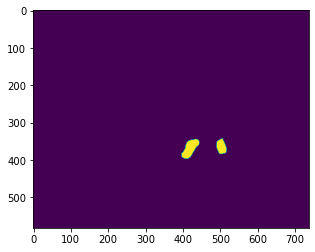

In [73]:
plt.imshow(preds[1]['prediction'][: , :, 0])

In [96]:
f=2

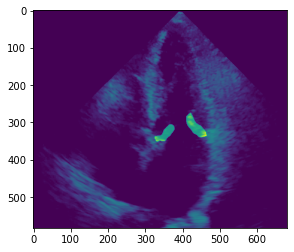

In [105]:
f += 1
plt.imshow(data[f]['video'][:, :, 20] + 255*preds[f]['prediction'][: , :, 20])

In [ ]:
plt.imshow(video[: , :, 0])

In [16]:
data = load_zipped_pickle('train.pkl')

In [17]:
video = RNMF_transform(data[50]['video'])

In [48]:
im = video[:, :, 0]
width, height = im.shape[0], im.shape[1]
bb = box_model(transform(transforms.ToPILImage()(torch.Tensor(im)).resize((128,128))).unsqueeze(0).cuda()).clamp(0,1)[0].cpu().detach().numpy()
print(bb)
bb = [bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]]
x1 = bb[0]*height
x2 = bb[2]*height
y1 = bb[1]*width
y2 = bb[3]*width
crop_im1 = crop_resize(transforms.ToPILImage()(torch.Tensor(im)), bb, 128, 128)

[0.45473978 0.36448416 0.27854148 0.25533417]
(373.3413587510586, 213.58771842718124, 602.0239101648331, 363.21354126930237)


In [57]:
x1, y1, x2, y2

(373.3413587510586, 213.58771842718124, 602.0239101648331, 363.21354126930237)

In [59]:
im.shape

(586, 821)

In [51]:
height, width

(821, 586)

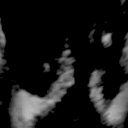

In [49]:
crop_im1

In [53]:
new_im.shape

(229, 150)

In [54]:
org_im.shape

(586, 821)

In [56]:
x2

602.0239101648331

In [61]:
crop_im = transform(crop_im1)
new_im = (transforms.ToTensor()(transforms.ToPILImage()(unet_model(crop_im.unsqueeze(0).cuda()).clamp(0,1)[0][0]).resize((int(x2)-int(x1), int(y2) -int(y1)))).cpu()>0.5)[0].float().numpy()
org_im = np.zeros((width, height))
org_im[int(y1):int(y2), int(x1):int(x2)] = new_im
#org_im = torch.Tensor(org_im).unsqueeze(0)

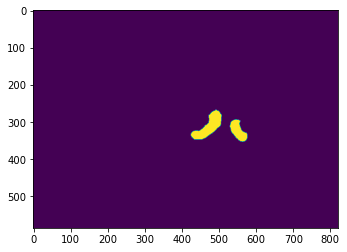

In [62]:
plt.imshow(org_im)

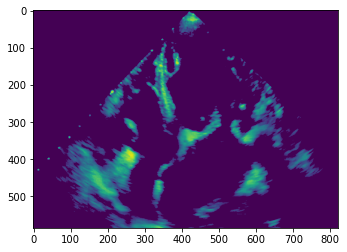

In [28]:
plt.imshow(im)

In [36]:
x1, x2, y1, y2

(266.47751063108444, 429.70281529426575, 299.24149629473686, 508.87084877491)

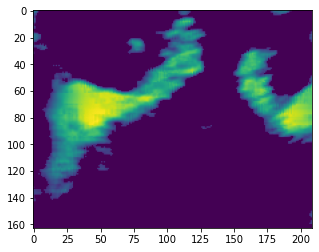

In [42]:
plt.imshow(im[int(x1):int(x2), int(y1)+80:80+int(y2)])

In [37]:
eighth = load_zipped_pickle("eighth_submission.pkl")
twelvth = load_zipped_pickle("twelvth_submission.pkl")
thirtythird = load_zipped_pickle("thirtythird_submission.pkl")
fourteenth = load_zipped_pickle("fourteenth_submission.pkl")
eleventh = load_zipped_pickle("eleventh_submission.pkl")
nineteenth = load_zipped_pickle("nineteenth_submission.pkl")

In [17]:
thirtythird = load_zipped_pickle("thirtythird_submission.pkl")
thirtysixth = load_zipped_pickle("thirtysixth_submission.pkl")
fourtyfourth = load_zipped_pickle("fourtyfourth_submission.pkl")
fifteenth = load_zipped_pickle("fifteenth_submission.pkl")

In [18]:
sample = load_zipped_pickle("sample.pkl")

In [16]:
preds = load_zipped_pickle("twentyseventh_submission.pkl")
for pred in preds:
    vid = pred['prediction']
    valve_aniso = np.empty_like(vid)
    for i in range(vid.shape[2]):
        fr = vid[: ,: , i]
        valve_diffused = mp.anisotropic_diffusion(fr, niter=2, kappa=20, option=3)
        valve_aniso[: ,: , i] = valve_diffused
    pred['prediction'] = valve_aniso

/home/mawskay/anaconda3/lib/python3.7/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/mawskay/anaconda3/lib/python3.7/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


In [19]:
for i in range(len(sample)):
    sample[i]['prediction'] = ((fifteenth[i]['prediction'].astype(int) + preds[i]['prediction'].astype(int) + fourtyfourth[i]['prediction'].astype(int) + thirtysixth[i]['prediction'].astype(int) + thirtythird[i]['prediction'].astype(int))/5) >= 0.5

In [20]:
save_zipped_pickle(sample, 'last_submission.pkl')

In [27]:
0.05*800

40.0